**<h1>Práctica computacional: modelo de Ising en 2D</h1>**

* <h4>Física Teórica 3</h4> 
* <h4>1er cuatrimestre 2024</h4> 
* <h4>Grupo 3: Arcuschin Moreno Nicolas, Borrell Trinidad, Brusco Agustin, Martínez Garbino Paula</h4> 

In [1]:
import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import norm
from tqdm.notebook import tqdm
from time import time
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

COLOR = "black"
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (16, 9)

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"

plt.rcParams["legend.fontsize"] = 20
plt.rcParams["axes.titlesize"] = 30
plt.rcParams["axes.labelsize"] = 25
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20

plt.rcParams["axes.grid"] = True

plt.rcParams["text.color"] = COLOR
plt.rcParams["text.color"] = COLOR
plt.rcParams["axes.labelcolor"] = COLOR
plt.rcParams["xtick.color"] = COLOR
plt.rcParams["ytick.color"] = COLOR
plt.rcParams["text.latex.preamble"] = "\n".join([r"\usepackage[version=3]{mhchem}"])

## 0. Definiciones pre-simulación

A continuación definimos las siguientes funciones:

* **`h(S)`**: calcula la energía por partícula de la red en el estado $S$ asumiendo que no hay campo magnético externo, y considerando condiciones de contorno periodicas, es decir, devuelve $\frac{H(S)}{L^2}$ con $H(S)=-\sum_{i,j=1}^L S_{ij}(S_{i-1 j}+S_{ij-1})$.

* **`metropolis(S, prob)`**: aplica el logaritmo de metropolis al estado $S$ tantas veces como sitios tiene la red. Mediante la función **`calculate_dE(S0, i, j, S)`** calcula la diferencia de energía al modificar la proyección de espín en la posición $(i, j)$.

* **`calculate_dE(S0, i, j, S)`**: calcula como se modifica la energía de la red $S$ al cambiar la proyección del espín en la posición $(i, j)$ considerando que el Hamiltoniano únicamente acopla primeros vecinos de la red, por ende, esta diferencia dependerá unicamente de estos 5 valores (el del espín modificado y sus cuatro primeros vecinos). En particular dado $H(S)$, modificando $S_{ij}$, tenemos que $\Delta E = 2 S_{ij} (S_{i-1j} + S_{ij-1} + S_{i+1j} + S_{ij+1})$.

In [2]:
@njit
def h(S: np.ndarray) -> float:
    """Calcula la energía (por partícula) de la red en el estado S."""
    H = 0
    for i in prange(S.shape[0]):
        for j in prange(S.shape[1]):
            H += -S[i, j] * (S[i - 1, j] + S[i, j - 1])
    return H / S.size  # Aca S.size ya nos dá la normalización por L^2


@njit
def calculate_dE(s0: int, i: int, j: int, S: np.ndarray) -> int:
    """Calcula la variación en la energía de la red al cambiar la proyección del spin \
en la posición (i, j).
    """
    L = S.shape[0]
    upper_i = (i + 1) % L  # Condición de periodicidad
    upper_j = (j + 1) % L  # Condición de periodicidad
    #    s3
    # s4 s0 s2
    #    s1
    s1, s2, s3, s4 = S[upper_i, j], S[i, upper_j], S[i - 1, j], S[i, j - 1]
    return 2 * s0 * (s1 + s2 + s3 + s4)


@njit
def metropolis(S: np.ndarray, prob: np.ndarray) -> tuple[np.ndarray, float, float]:
    """Aplica L² pasos del algoritmo de Metropolis al estado S de la red de L×L spines \
usando las probabilidades provistas.
    """
    dm = 0
    de = 0
    # La consigna dice que hay que aplicar el algoritmo de metrópolis por cada
    # sitio en la red, es decir, L cuadrado veces.
    for _ in range(S.size):
        i, j = np.random.choice(S.shape[0], 2)  # Las coordenadas al azar en [0, L)²
        sij = S[i, j]  # El spin de esa posición
        opp_sij = -sij  # El spin al que podría transicionar
        dE_sij = calculate_dE(sij, i, j, S)
        # La diferencia de energía al transicionar de sij a opp_sij
        p = np.random.random(1)
        if (  # El spin cambia su estado si:
            dE_sij <= 0  # La diferencia de energía es negativa o cero
            or (dE_sij == 4 and p < prob[0])  # Con prob[0] si dE = 4
            or (dE_sij == 8 and p < prob[1])  # Con prob[1] si dE = 8
        ):
            S[i, j] = opp_sij  # El spin cambia de estado
            de += dE_sij
            dm += opp_sij
    return S, dm / S.size, de / S.size

## 1.1. Termalización y primera simulación

A continuación definimos la función **`termalize_S(S,prob)`** que evoluciona la red `S` hasta garantizar la termalización del sistema. Esto es, cuando los estados producidos al aplicar más pasos del algoritmo de metropolis estén distribuidos según el ensamble canónico.

Para que se cumpla esta condición de forma genérica consideramos aplicar el algoritmo de metropolís hasta que el promedio de los últimos 100 incrementos de la energía y de la magnetización sean menores a $10^{-6}$. Esta condición puede entenderse intuitivamente como que le pedimos a la red que las variaciones que sufrió en $E$ y $M$ en los últimos 100 pasos se compensen entre sí, de manera que ambas cantidades estén fluctuando alrededor de valores medios definidos.

Aquí, la ventana de 100 pasos se eligió con el fin de tener una ventana que permita estudiar la historia reciente de ambas cantidades sin ser tan extensa como para que las variaciones espontaneas de $M$ cerca de la $T_c$ impidan cumplir la condición de equilibrio. De forma similar, el umbrál de $10^{-6}$ para las variaciones promedio se eligió confirmando visualmente que este permite garantizar la termalización de redes para los valores de $L$ y $T$ estudiados en este trabajo.

In [3]:
@njit
def termalize_S(S: np.ndarray, prob: np.ndarray) -> np.ndarray:
    """Aplica el algoritmo metropolis a una red S hasta que se alcanza el equilibrio \
térmico.
    """
    n = 0
    n_check = 100  # Tamaño de la ventana en la que miramos la variación de la energía
    # Nota: n_check es suficientemente chico como para que las variaciones espontaneas
    # del valor medio de M no afecten la condición de equilibrio.
    historic_de = np.zeros(n_check)
    historic_dm = np.zeros(n_check)
    while (  # Iterar mientras:
        (n < n_check)  # Hayamos hecho menos de n_check pasos
        # O si en los últimos n_check pasos:
        # las variaciones de E no se compensan
        or (np.abs(np.sum(historic_de) / (n_check)) > 1e-6)
        # las variaciones de M no se compensan
        or (np.abs(np.sum(historic_dm) / n_check) > 1e-6)
    ):
        S, dm, de = metropolis(S, prob)
        historic_de[n % n_check] = de
        historic_dm[n % n_check] = dm
        n += 1
    return S

A continuación ejemplificamos el algoritmo de termalización con una red de $256 \times 256$, partiendo de una condición inicial de "unos" y fijando la temperatura en $T = 2.2$. En cada paso (de Montercarlo) del algoritmo Metropolis guardamos además la energía y magnetización de la red para luego graficarlos.

En el gráfico podemos observar cómo en los primeros pasos de la evolución tanto $E$ como $M$ crecen o decrecen casi monotónicamente y a medida que se aplica el algoritmo de metropolis, estos se estacionan alrededor de un valor medio definido (con cierta varianza aparentemente constante).

Variando la temperatura y el tamaño de la red pudimos observar que el algoritmo presentado garantiza la termalización de la red y el mismo finaliza en el orden de los cientos de pasos.

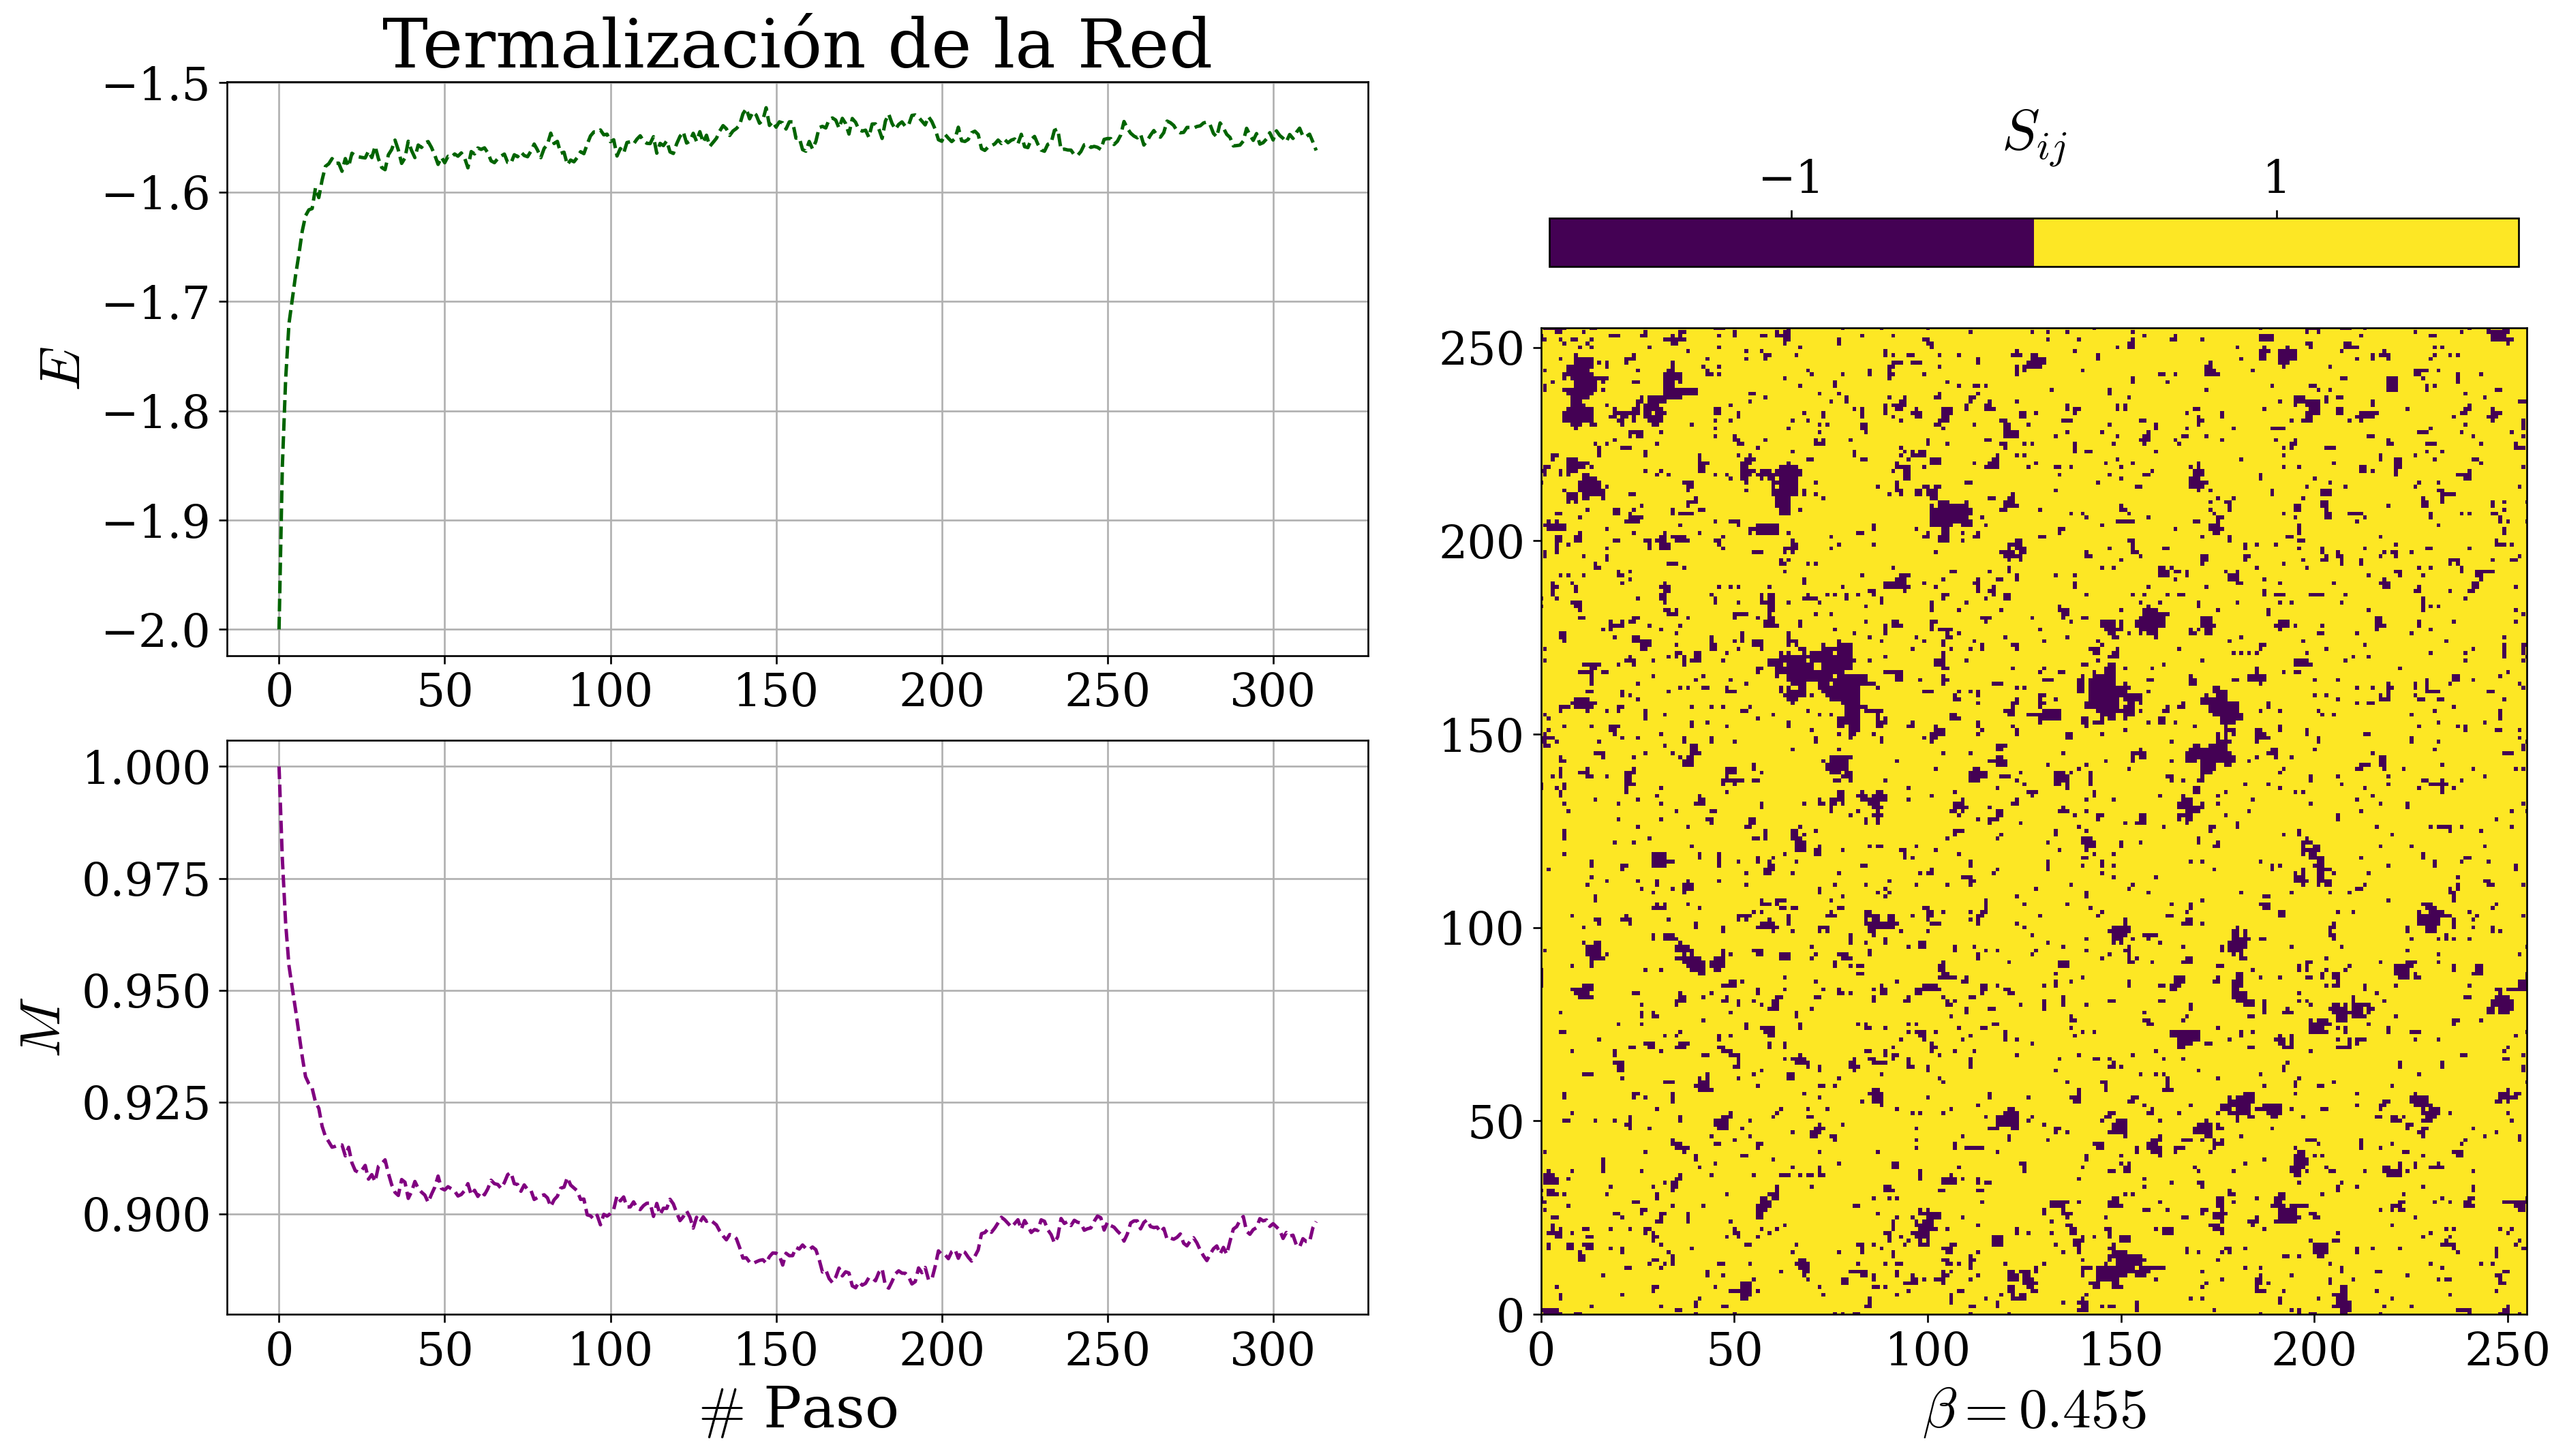

In [4]:
L = 256  # Lado de la red
T = 2.2  # Temperatura a la que vamos a termalizar
beta = 1 / T
prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])

# Estado inicial
if T < 2.27:
    S = np.ones((L, L), dtype=int)
else:
    S = 2 * np.random.randint(2, size=(L, L)) - 1

n = 0  # El paso del loop
M_vals = [np.mean(S), ]  # Magnetización en función del paso
E_vals = [h(S), ]  # Energia por particula en funcion del paso
n_check = 100  # Tamaño de la ventana en la que miramos la variación de la energía
historic_de = np.zeros(n_check)  # Acá vamos a almacenar los últimos valores de `de`
historic_dm = np.zeros(n_check)  # Idem para `dm`
while (
    (n < n_check)  # Dejamos pasar al menos n_check pasos para llenar una ventana
    # Luego el loop continua mientras la variación promedio de E o M en los últimos
    # n_check pasos sea mayor que el umbral:
    or (np.abs(np.sum(historic_de)/(n_check)) > 1e-6)
    or (np.abs(np.sum(historic_dm)/n_check) > 1e-6)
):
    S, dm, de = metropolis(S, prob)
    M_vals.append(M_vals[-1] + dm)  # Magnetización de S en este paso
    E_vals.append(E_vals[-1] + de)  # Energía de S en este paso
    historic_de[n%n_check] = de  # Agregamos `de` a la ventada
    n+=1

# Graficamos E, M y la red al final de la termalización.
fig, axs = plt.subplot_mosaic(
    """
    AACC
    BBCC
    """,
    # constrained_layout=True
    tight_layout=True
)
axs["A"].plot(E_vals, color="darkgreen", linestyle='--')
axs["B"].plot(M_vals, color="purple", linestyle='--')

spin_colors = axs["C"].imshow(S)
axs["C"].grid(False)
axs["C"].set_ylim(0, L - 1)
axs["C"].set_xlim((0, L - 1))
plt.colorbar(
    spin_colors, ax=axs["C"], orientation="horizontal", location="top", label="$S_{ij}$",
    boundaries=[-2, 0, 2], values=[-1, 1], ticks=[-1, 1], shrink=0.85,
)

axs["A"].set_title("Termalización de la Red")
axs["A"].set_ylabel("$E$")
axs["B"].set_ylabel("$M$")
axs["B"].set_xlabel("$\#$ Paso")
axs["C"].set_xlabel(rf"$\beta = {beta:.3g}$")
plt.show()

## 1.2. Promedios: estudio de las variaciones de los promedios en función de T y L

Una vez termalizada la red del punto anterior, aplicar $L^2$ veces el algoritmo de Metropolis nos devuelve con seguridad un red en el estado $S$ con probabilidad dada por la distribución del ensamble canónico para la temperatura fijada.

Ahora, para medir la energía y magnetización medias del ensamble ($\langle E \rangle$ y $\langle |M| \rangle$) debemos promediar las energías y magnetizaciones medidas en las redes `S` generadas con el algoritmo. Como estas son variables aleatorias con cierta varianza, buscamos entender cuantas mediciones de $E$ y $M$ debemos hacer para que el promedio que calculemos converja a un mismo número (sin quedarnos cortos ni medir de más).

Para esto, definimos un máximo de mediciones que estamos dispuestos a hacer para calcular los promedios (`N_max = 50_000`) y comenzamos a aplicar el algoritmo de Metropolis midiendo $M$, $E$ y calculando los promedios de todas las mediciones que hicimos hasta cada paso. Luego, si en cada paso comprobamos cómo variaron los promedios calculados, podemos dejar de medir cuando observemos que estas varianciones son suficientemente chicas un número suficientemente grande de veces (proponemos 500).

A continuación se muestra un ejemplo de esta lógica aplicada a la red que termalizamos en el punto anterior. En los gráficos se pueden ver las mediciones de $E$ y $M$ así como los promedios calculados considerando las mediciones hasta el paso $N$ ($\langle E \rangle_{<N}$ y $\langle |M| \rangle_{<N}$ respectivamente) y los promedios finales a los que convergen las mediciones cuando las variación entre promedios calculados es suficientemente chica.

Variando la temperatura y el tamaño de la red pudimos observar que el algoritmo presentado garantiza la convergencia de los promedios en el orden de los miles de pasos para las redes más grandes, y decenas de miles para redes más chicas.

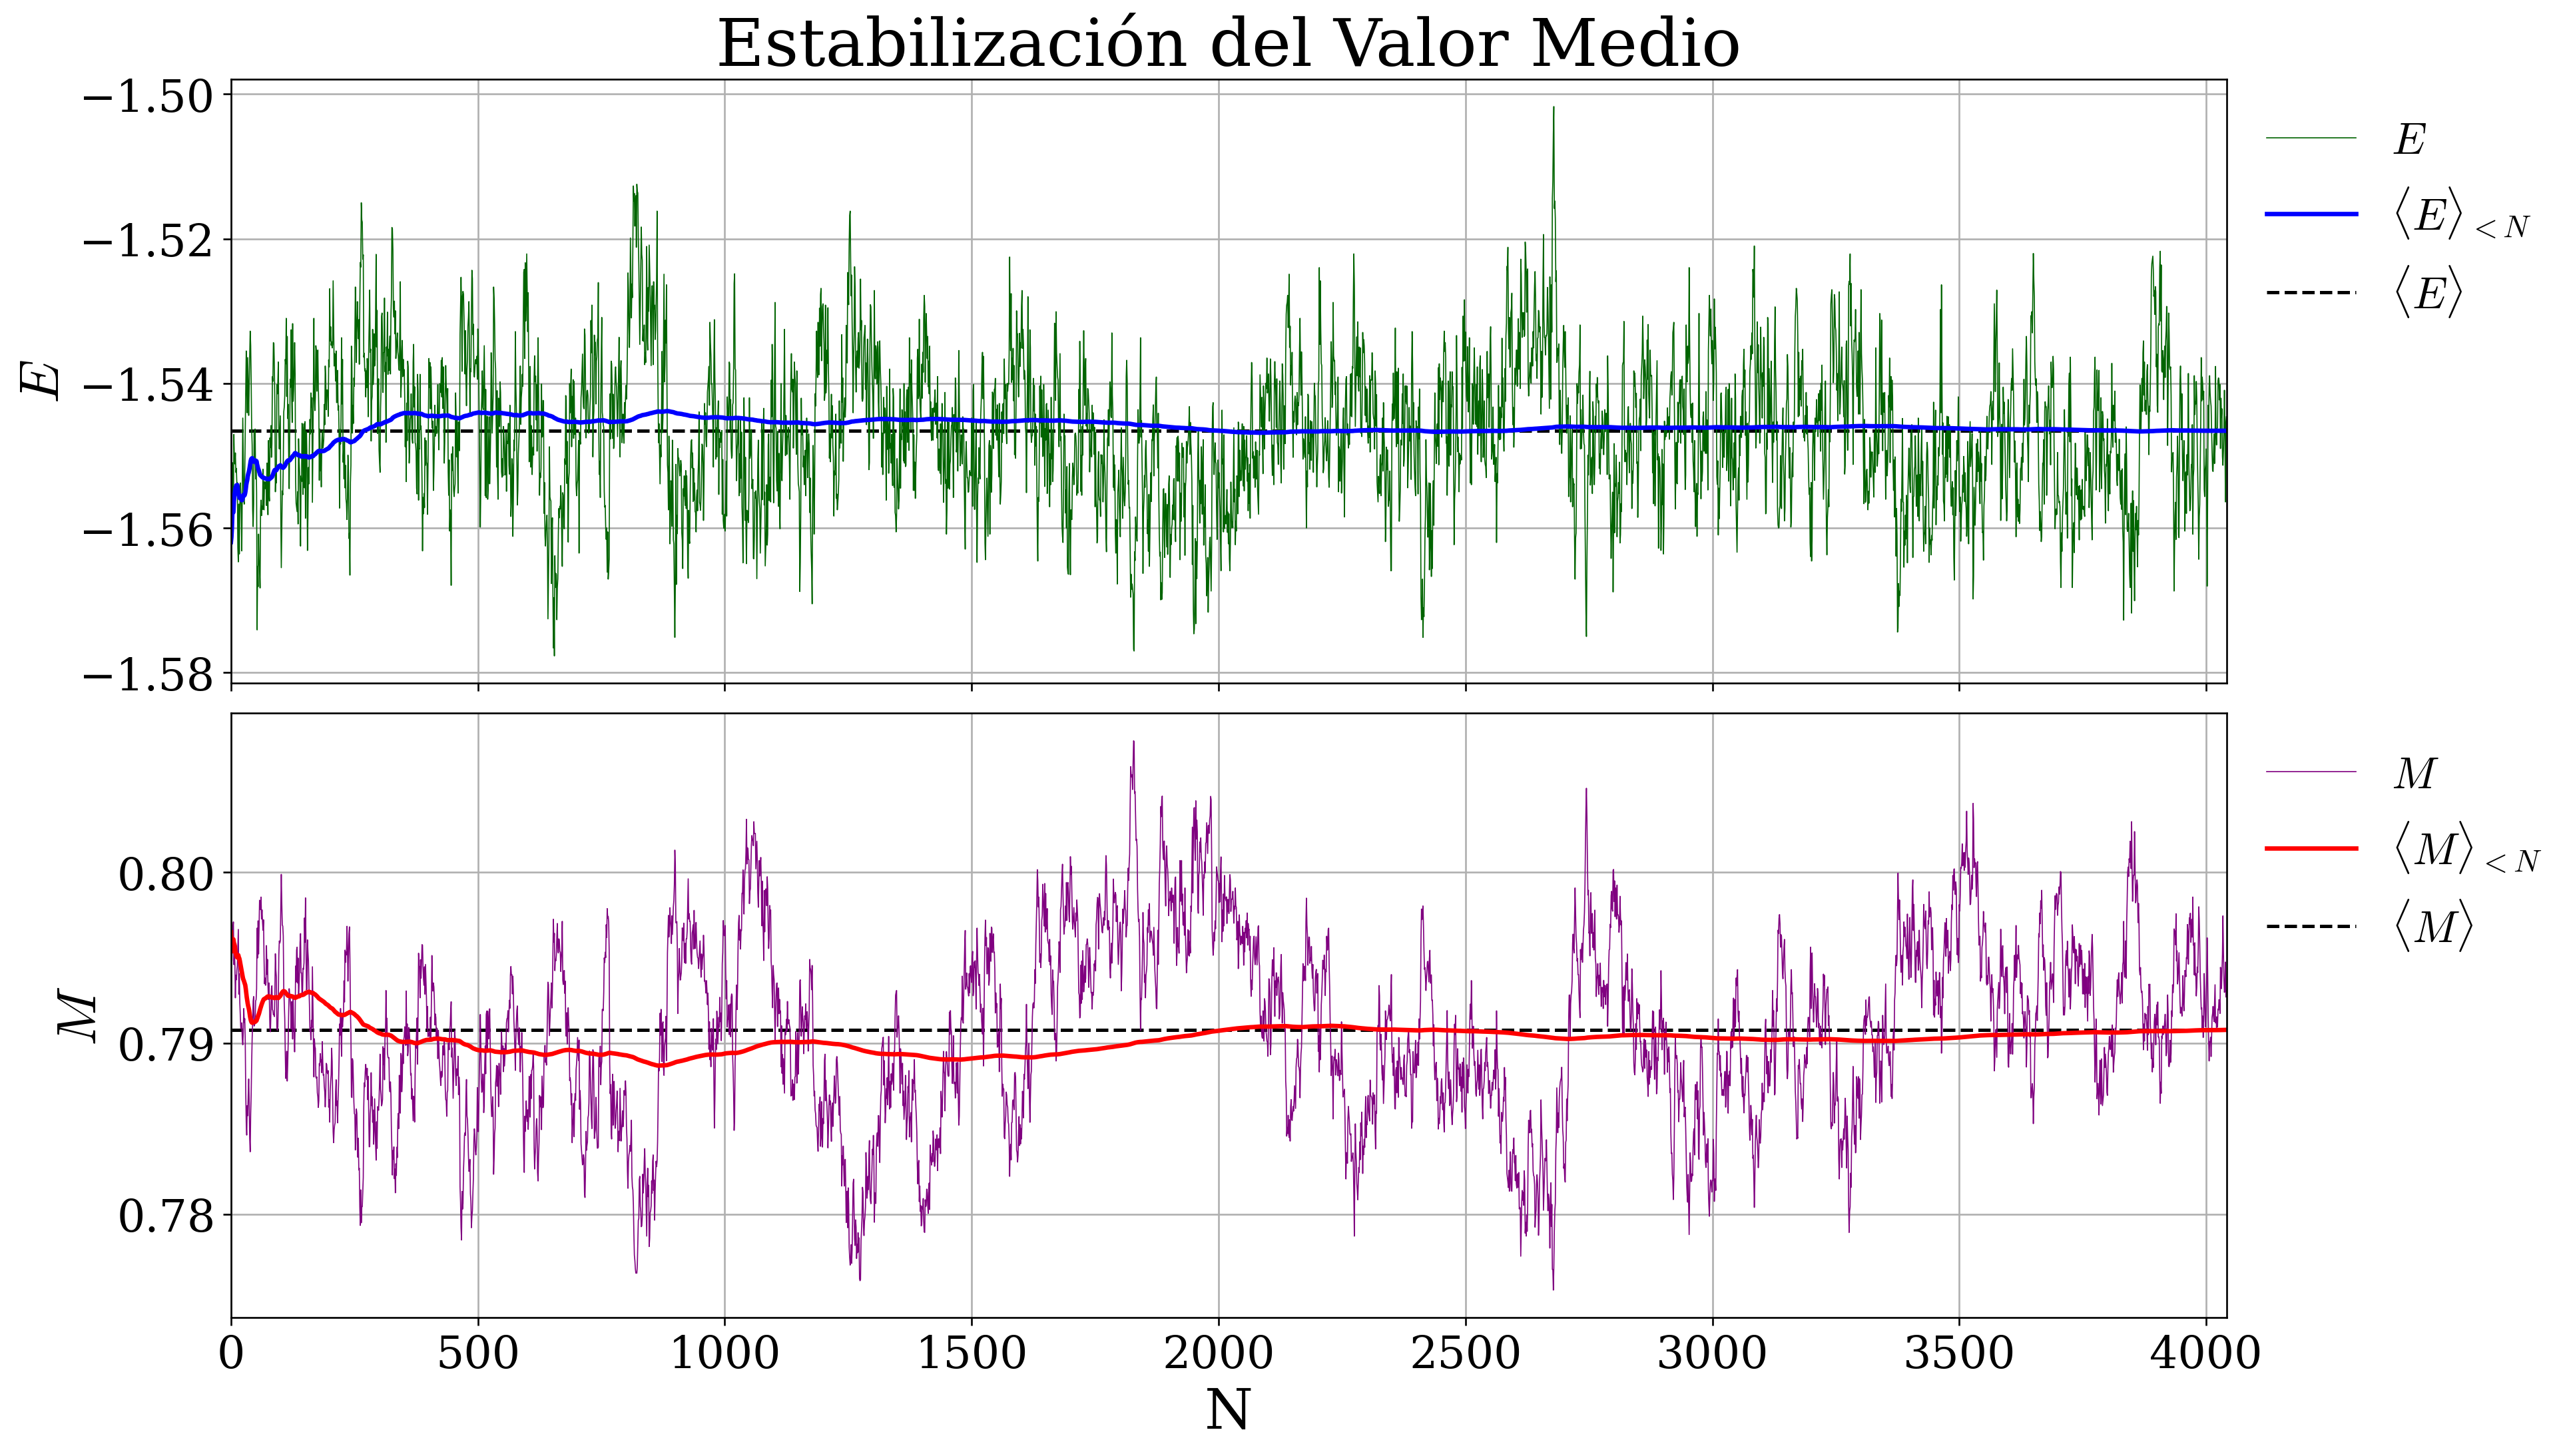

In [5]:
N_max = 50_000
M_vals = np.zeros(N_max)  # Magnetización en función del paso
E_vals = np.zeros(N_max)  # Energía por particula en funcion del paso
M_avgs = np.zeros(N_max)  # M_avgs[i] = mean(|M[:i+1]|)
E_avgs = np.zeros(N_max)  # E_avgs[i] = mean(E[:i+1])

M_vals[0] = np.sum(S) / S.size  # Promedio de spines
E_vals[0] = h(S)  # Energía por partícula
M_avgs[0] = np.abs(M_vals[0])
E_avgs[0] = E_vals[0]

n = 1
convergence_counter = 0
while (n < N_max) and (convergence_counter < 500):
    S, dm, de = metropolis(S, prob)
    M_vals[n] = M_vals[n - 1] + dm
    E_vals[n] = E_vals[n - 1] + de
    M_avgs[n] = np.mean(np.abs(M_vals[:n+1]))
    E_avgs[n] = np.mean(E_vals[:n+1])
    # Si la diferencia absoluta entre este paso y el siguiente es menor a 10e-6
    # añado uno al contador de promedio.
    # Si esto sucede 500 veces decimos que el sistema tiene un promedio estable
    if (abs(E_avgs[n-1] - E_avgs[n]) < 1e-6) and abs(M_avgs[n-1] - M_avgs[n] < 1e-6):
        # Quizá podría mejorarse pidiendo algo con respecto al error relativo
        convergence_counter += 1
    n += 1
M_vals = M_vals[:n]
E_vals = E_vals[:n]
M_avgs = M_avgs[:n]
E_avgs = E_avgs[:n]

# Graficamos E, M y la red al final de la termalización.
fig, axs = plt.subplots(2, 1, constrained_layout=True, sharex=True)
axs[0].plot(E_vals, '-', lw=0.5, c="darkgreen", label="$E$")
axs[0].plot(E_avgs, "-", c="b", lw=2, label=r"$\langle E \rangle_{<N}$")
axs[0].axhline(E_avgs[-1], ls="--", c="k", alpha=1, zorder=0, label=r"$\langle E \rangle$")
axs[1].plot(M_vals, '-', lw=0.5, c="purple", label="$M$")
axs[1].plot(M_avgs, "-", c="r", lw=2, label=r"$\langle M \rangle_{<N}$")
axs[1].axhline(M_avgs[-1], ls="--", c="k", alpha=1, zorder=0, label=r"$\langle M \rangle$")

axs[0].set_title("Estabilización del Valor Medio")
axs[0].set_ylabel("$E$")
axs[1].set_ylabel("$M$")
axs[1].set_xlabel("N")
for ax in axs:
    ax.legend(bbox_to_anchor=(1, 1), loc="upper left", frameon=False)
    ax.set_xlim(left=0, right=n)
plt.show()

A continuación hicimos un estudio de las variaciones de los promedios, analizando los pasos necesarios para que el promedio calculado sea lo suficiemntemente bueno en función del tamaño de la red $L$ y la temperatura $T$. Para ello definimos las siguientes funciones:

* **`create_dense_domain_around_tc(temperatura_critica, n_puntos)`**: Generamos un dominio de temperaturas con mayor densidad de puntos alrededor de la temperatura crítica. Para esto sampleamos en puntos equiespaciados la inversa de la distribución de probabilidad acumulada de una gaussiana con centro en la temperatura crítica.

* **`do_sim_until_convergence(S, prob)`**: Devuelve el $n$ tal que los promedios son 'buenos' dada una red $S$. Para esto aplicamos la lógica explicada arriba dónde se nos da una red $S$ termalizada y luego se aplica metropolis los $n$ pasos necesarios hasta que se cumplan $500$ pasos en los que la diferencia entre valores promedios sucesivos de energía y magnetización sean menores a $10^{-6}$. Para ese $n$ resultante podemos decir que el promedio que vayamos a calcular es suficientemente "bueno".

* **`get_stable_ns_for_measurement(T_arr, S0)`**: Esta función automatiza la obtención de pasos a dar para obtener buenos promedios para un arreglo de temperaturas. En primer lugar impone una condición inicial sobre la red $S$ (en general será matriz de unos para temperaturas bajas y matriz de valores aleatorios para temperaturas altas) y la termaliza. Luego para cada temperatura obtiene el $n$ tal que el promedio es bueno llamando a la función **`do_sim_until_convergence(S, prob)`**. Finalmente devuelve el $n$ de cada temperatura en la lista **`n_promedios`**.

In [6]:
def create_dense_domain_around_tc(
    temperatura_critica: float,
    n_puntos: int,
) -> np.ndarray:
    """Genera un array de temperaturas alrededor de la temperatura crítica distribuidos\
 de manera proporcional a una distribución gaussiana.
    """
    distribucion = norm(loc=temperatura_critica, scale=0.5)  # Gaussiana
    # Genero un array de valores equiespaciados entre 0 y 1 para samplear la ICDF
    dominio_equiespaciado = np.linspace(1, 0, n_puntos + 2)[1:-1]
    # Evaluo la ICDF en los valores generados
    dominio_denso_en_tc = distribucion.isf(dominio_equiespaciado)
    return dominio_denso_en_tc


@njit
def do_sim_until_convergence(S: np.ndarray, prob: np.ndarray) -> int:
    """Devuelve el número de pasos montecarlo del algoritmo de Metropolis que \
fueron necesarios para que los promedios de la energía y magnetización de S converjan.
    """
    N_max = 50_000
    M = np.zeros(N_max)  # Magnetización en función del paso
    E = np.zeros(N_max)  # Energía por particula en funcion del paso
    M_avg = np.zeros_like(M)  # M_avg[i] = mean(|M[:i+1]|)
    E_avg = np.zeros_like(E)  # E_avg[i] = mean(E[:i+1])

    M[0] = np.sum(S) / S.size  # Promedio de spines
    E[0] = h(S)  # Energía por partícula
    M_avg[0] = np.abs(M[0])
    E_avg[0] = E[0]

    n = 1
    average_counter = 0
    while (n < N_max) and (average_counter < 500):
        S, dm, de = metropolis(S, prob)
        M[n] = M[n - 1] + dm
        E[n] = E[n - 1] + de
        M_avg[n] = np.mean(np.abs(M[: n + 1]))
        E_avg[n] = np.mean(E[: n + 1])
        # Si la diferencia absoluta entre este paso y el siguiente es menor a 10e-6
        # añado uno al contador de promedio
        # Si esto sucede 500 veces decimos que el sistema tiene un promedio estable
        if (abs(E_avg[n - 1] - E_avg[n]) < 1e-6) and (
            abs(M_avg[n - 1] - M_avg[n]) < 1e-6
        ):
            # Podría mejorarse pidiendo algo con respecto al error relativo
            average_counter += 1
        n += 1
    return n


def get_stable_ns_for_measurement(
    T_arr: np.ndarray,
    S0: list[np.ndarray],
) -> np.ndarray:
    n_promedios = np.zeros_like(T_arr)
    for ti in tqdm(range(T_arr.size), desc="T", total=T_arr.size):
        T = T_arr[ti]
        beta = 1 / T
        prob = np.exp(-beta * np.array([4, 8]))
        if T < 2.27:
            S = S0[0]  # T bajas
        else:
            S = S0[1]  # T altas
        S = termalize_S(S, prob)
        n_promedios[ti] = do_sim_until_convergence(S, prob)
    return n_promedios

A continuación estimamos los $N$ necesarios para obtener buenos promedios para una grilla de $101$ valores de temperaturas y $6$ valores de tamaño de red. Como calcular estos valores requiere varias horas, se guardaron los resultados en archivos `.csv` con el fin de ahorrar tiempo de ejecución en el futuro.

Además, como se observó que para redes pequeñas (de 16, 32 y 64 spins por lado) ocasionalmente se observaban valores de $N$ extremadamente altos de manera inconsistente, se realizó una segunda tanda de mediciones para estas redes que luego promediamos con las primeras, obteniendo resultados más razonables de esta manera.

In [7]:
T_arr = create_dense_domain_around_tc(2.27, 101)
L_arr = 2 ** np.arange(4, 9 + 1)  # 16, 32, 64, 128, 256, 512

# Calculamos para todos los L
try:
    df_0 = pd.read_csv("LT_matrix_0.csv", index_col=0, dtype=float)
    df_0.columns = [int(L_str) for L_str in df_0.columns]
    df_0 = df_0.map(int)
except FileNotFoundError:
    df_0 = pd.DataFrame(index=T_arr, columns=[*L_arr])
    for L in L_arr:
        # Definimos estados iniciales para S y los usamos luego en función de la
        # temperatura a la que queremos trabajar:
        print(f"Calculando para {L = }")
        S0 = [np.ones((L, L), dtype=int), 2 * np.random.randint(2, size=(L, L)) - 1]
        df_0[L] = get_stable_ns_for_measurement(T_arr, S0)
        print()

    df_0.to_csv("LT_matrix_0.csv")

# Calculamos de nuevos para los L más chicos que tienen mayor varianza
# y luego promediamos los resultados
try:
    df_1 = pd.read_csv("LT_matrix_1.csv", index_col=0, dtype=float)
    df_1.columns = [int(L_str) for L_str in df_1.columns]
    df_1 = df_1.map(int)
except FileNotFoundError:
    df_1 = pd.DataFrame(index=T_arr, columns=[*L_arr])
    for L in L_arr[:3]:
        # Definimos estados iniciales para S y los usamos luego en función de la
        # temperatura a la que queremos trabajar:
        print(f"Calculando para {L = }")
        S0 = [np.ones((L, L), dtype=int), 2 * np.random.randint(2, size=(L, L)) - 1]
        df_1[L] = get_stable_ns_for_measurement(T_arr, S0)
        print()

    df_1.to_csv("LT_matrix_1.csv")

# Promediamos los resultados repetidos
df_n = round((df_0 + df_1) / 2)
df_n.fillna(df_0, inplace=True)
df_n = df_n.map(int)
df_n.to_csv("LT_matrix.csv")

Luego, para poder acceder a los valores calculados previamente al momento de querer realizar mediciones en una red definimos la función **`get_n_from_matrix`** que dados un $L$, un $T$ y la matriz que obtuvimos arriba, devuelva un $N$ que garantice la convergencia de los promedios sin tener que estar revisando paso a paso si estos continuan variando.

In [8]:
def get_n_from_matrix(L: int, T: float) -> int:
    # Cargamos los N precalculados
    df_n = pd.read_csv("LT_matrix.csv", index_col=0, dtype=float)
    df_n.columns = [int(L_str) for L_str in df_n.columns]
    df_n = df_n.map(int)
    # Extraemos los rangos de T y L y los valores de N para cada par (T, L)
    L_vals = df_n.columns.to_numpy(dtype=float)
    T_vals = df_n.index.to_numpy(dtype=float)
    N_grid = df_n.to_numpy(dtype=int)
    # Buscamos los valores más cercanos:
    row_num = np.argmin(abs(T_vals - T))
    col_num = np.argmin(abs(L_vals - L))
    n_vecinos = 6
    # Promedio a n vecinos en T
    N_medio = np.mean(N_grid[max(row_num-n_vecinos//2, 0):row_num+n_vecinos//2, col_num])
    return int(np.round(N_medio))

Para generalizar a valores de $L$ y $T$ en los que no estudiamos ninguna red, implementamos una lógica simple de interpolación de la matriz tal que **`get_n_from_matrix`** devuelva un valor de $N$ asociado al $L$ más cercano al $L$ en el que evaluamos la función y que sea el promedio de los $N$ para las 6 temperaturas más cercanas a la solcitada.

A continuación mostramos un gráfico que ilustra la alta varianza de los $N$ hallados en función de la temperatura, y cómo al tomar este promedio para las 6 temperaturas vecinas se obtiene una interpolación más robusta a _outliers_.

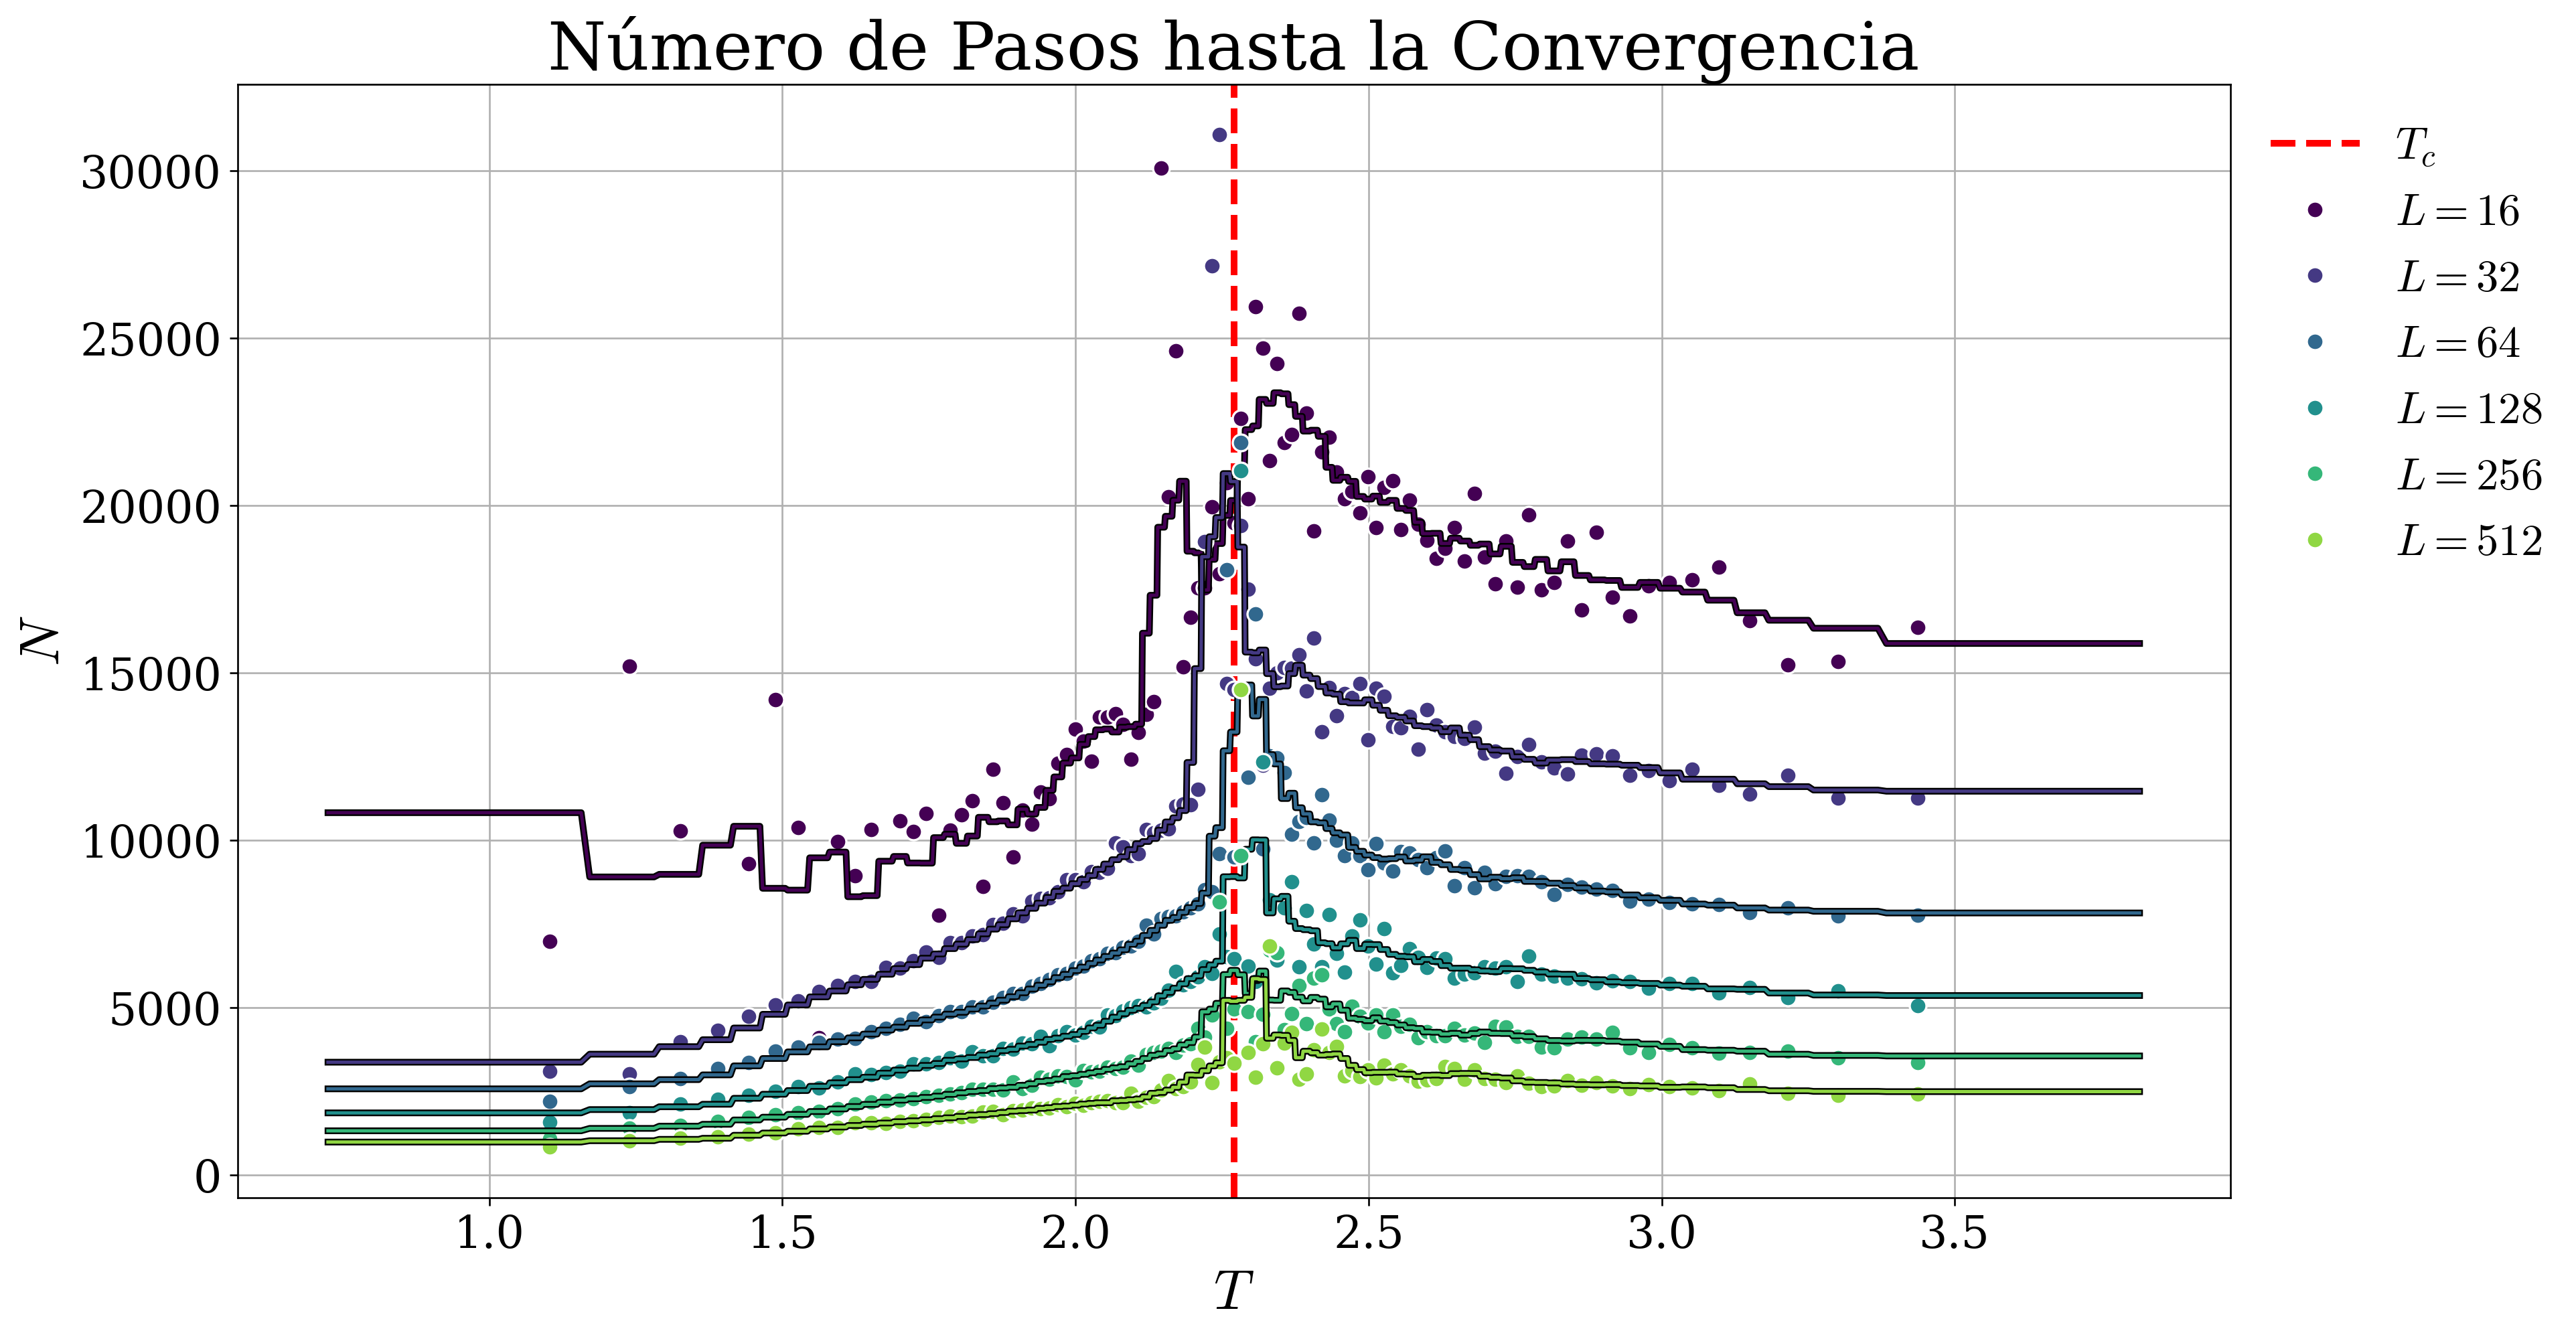

In [9]:
fig, ax = plt.subplots()
ax.axvline(2.27, c="r", ls="--", lw=3, label="$T_c$")
L_colors = cm.ScalarMappable(LogNorm(L_arr[0], L_arr[-1] * 2), cmap="viridis")
T_dense = create_dense_domain_around_tc(2.27, 1000)
LT_matrix = df_n.to_numpy()
for li, L in enumerate(L_arr):
    ax.plot(
        T_arr,
        LT_matrix[:, li],
        ".",
        ms=15,
        mec="w",
        mew=1,
        c=L_colors.to_rgba(L),
        label=f"${L = }$",
    )
    ax.plot(
        T_dense, [get_n_from_matrix(L, T) for T in T_dense], "-", c="k", lw=3
    )
    ax.plot(
        T_dense, [get_n_from_matrix(L, T) for T in T_dense], "-", c=L_colors.to_rgba(L)
    )
ax.legend(bbox_to_anchor=(1, 1), loc="upper left", frameon=False)
ax.set_title("Número de Pasos hasta la Convergencia")
ax.set_ylabel("$N$")
ax.set_xlabel("$T$")
plt.show()

## 2. Transición de fase

A continuación, considerando los estudios previos, calculamos la energía media por partícula, la magnetización media, la suceptibilidad y el calor específico. La energía y magnetización media las calculamos tomando la media de estos valores sobre el sistema una vez que este termalizó y que se tomaron pasos suficientes para hacer un buen promedio. Por otro lado, la suceptibilidad y el calor específico los calculamos considerando la varianza de la energía y de la magnetización, utilizando las siguientes relaciones y que $k = 1$.

- $\langle \Delta E ^ 2 \rangle = T^2 N c_v$

- $\langle \Delta M ^ 2 \rangle = T N \chi$

Para ello usamos las funciones: 

* **`phase_transition(T, prob)`**: en esta función se termaliza una red $S$ y luego se aplica **`n_stable`** veces el algoritmo metropolis para obtener los promedios de energía y magnetización. Esto último se hace en la función **`do_n_steps_of_simulation(S, prob)`**, y la idea es que el valor de  **`n_stable`**  se base en el estudio previo hecho para tomar buenos promedios. Obtenemos la media y la varianza de la energía, la magnetización y la red resultante.

* **`do_n_steps_of_simulation(S, prob)`**: aplica el algoritmo de metropolis **`n_stable`** pasos.

In [6]:
@njit
def do_n_steps_of_simulation(S, N, prob):
    M = np.zeros(N)  # Magnetización en función del paso
    E = np.zeros(N)  # Energía por particula en funcion del paso
    M[0] = np.sum(S) / S.size  # Promedio de spines
    E[0] = h(S)  # Energía por partícula

    for n in range(1, N):
        S, dm, de = metropolis(S, prob)
        M[n] = M[n - 1] + dm
        E[n] = E[n - 1] + de

    return E, M


@njit
def phase_transition(T, n_stable, S0):
    beta = 1 / T
    dE = np.array([4, 8])  # únicos Delta_E positivos
    prob = np.exp(-beta * dE)

    # Termalizamos el sistema
    S = termalize_S(S0, prob)
    # Lo estabilizamos
    E, M = do_n_steps_of_simulation(S, n_stable, prob)

    avg_E = np.sum(E) / n_stable
    avg_M = np.sum(np.abs(M)) / n_stable

    var_E = np.sum((E - avg_E) ** 2) / (n_stable - 1)
    var_M = np.sum((np.abs(M) - avg_M) ** 2) / (n_stable - 1)

    return avg_E, avg_M, var_E, var_M, S

A continuación observamos los resultados obtenidos para una red de dimensión $64$ x $64$. Usamos del punto previo la función que nos define un dominio con mayor densidad de puntos alrededor de la temperatura crítica y a su vez usando los valores obtenidos dado un valor de $T$ y $L$ para tomar buenos promedios. A su vez, considerando condiciones iniciales donde para temperaturas bajas (menores a la crítica) tenemos una matriz de unos mientras que para temperaturas altes (mayores a la crítica) tenemos una matriz aleatoria de unos y menos unos.

In [51]:
L = 64  # Dimensiones de la red

T_arr = create_dense_domain_around_tc(2.27, 51)
mean_E_T = np.zeros_like(T_arr)
mean_M_T = np.zeros_like(T_arr)
var_E_T = np.zeros_like(T_arr)
var_M_T = np.zeros_like(T_arr)

In [52]:
T_threshold = 2.27

T = T_arr[0]
S0 = [np.ones((L, L), dtype=int), 2 * np.random.randint(2, size=(L, L)) - 1]
if T < T_threshold:
    S = S0[0]  # T bajas
else:
    S = S0[1]  # T altas

for i, T in tqdm(enumerate(T_arr)):
    n_stable = get_n_from_matrix(L, T)
    mean_E, mean_M, var_E, var_M, S = phase_transition(T, n_stable, S)
    mean_E_T[i] = mean_E
    mean_M_T[i] = mean_M
    var_E_T[i] = var_E
    var_M_T[i] = var_M

0it [00:00, ?it/s]

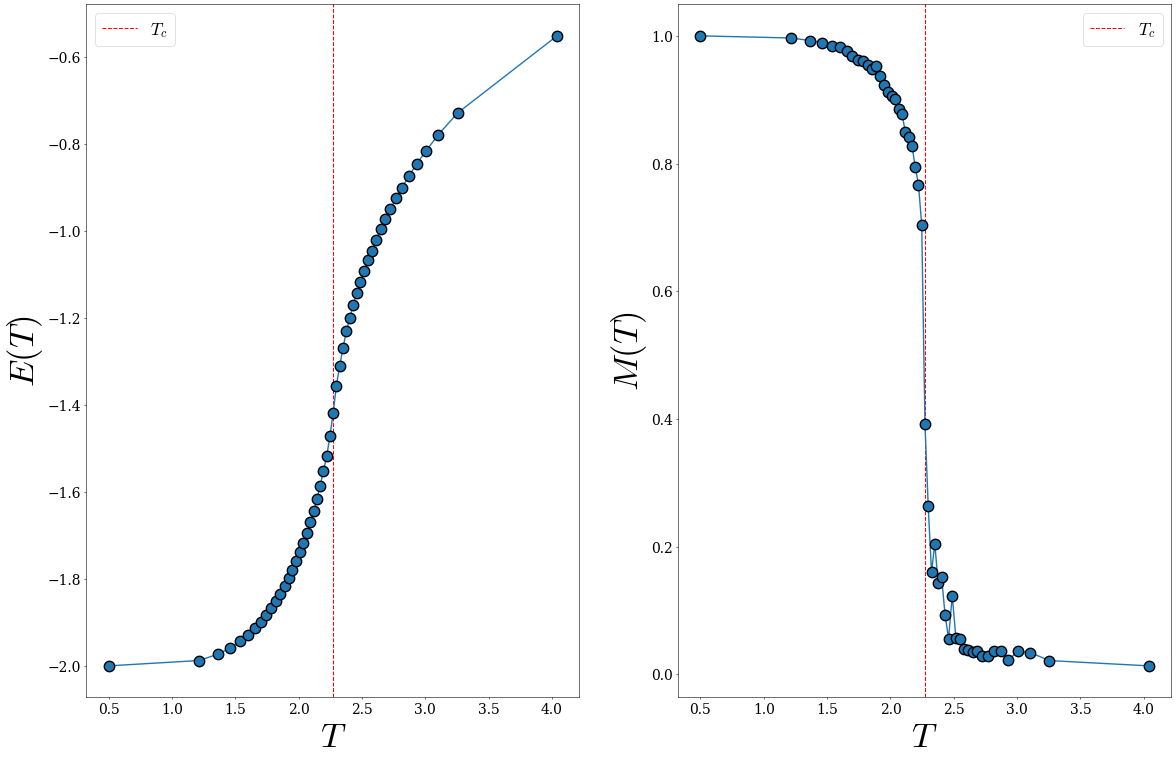

In [42]:
plt.subplot(1, 2, 1)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, mean_E_T, '-o', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel('$E(T)$')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, mean_M_T, '-o', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$M(T)$')
plt.grid()
plt.legend()
plt.show()

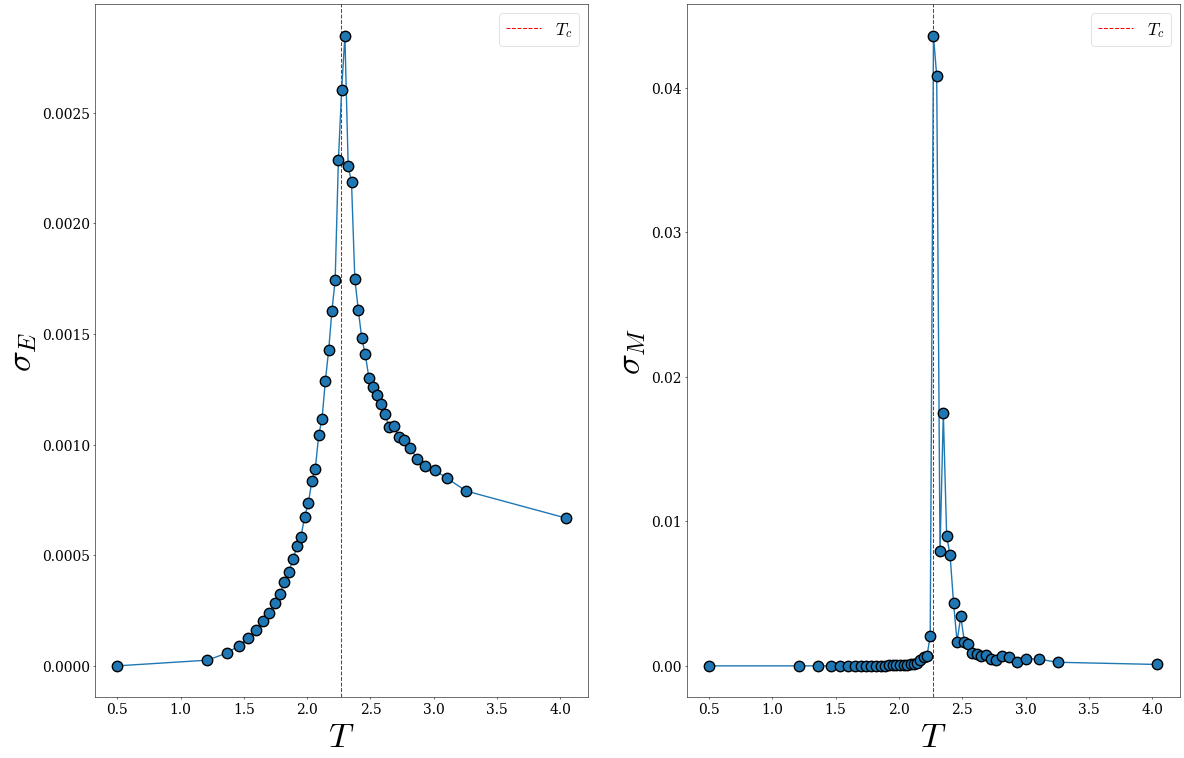

In [43]:
plt.subplot(1, 2, 1)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, var_E_T, 'o-', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$\langle \Delta E ^ 2 \rangle$')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, var_M_T, 'o-', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$\langle \Delta M ^ 2 \rangle$')
plt.legend()
plt.grid()
plt.show()

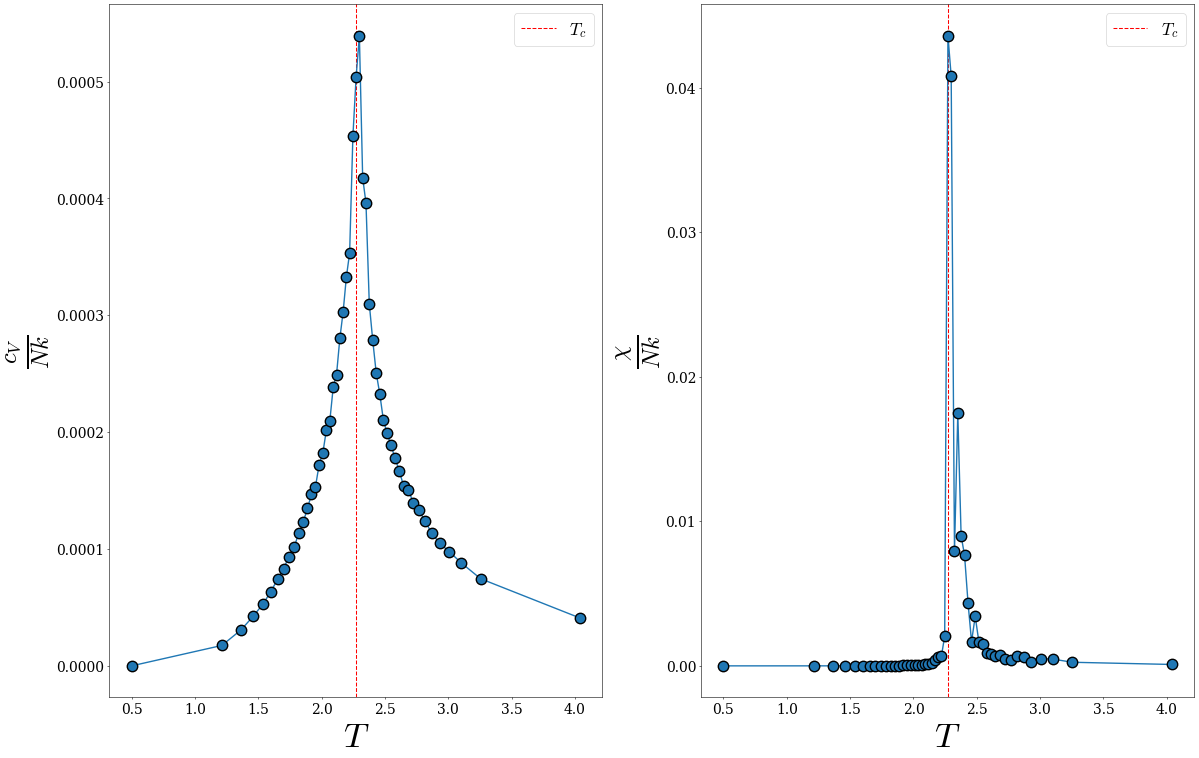

In [44]:
plt.subplot(1, 2, 1)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, var_E_T*(1/T_arr**2), 'o-', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$\frac{c_V}{N}$')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, var_M_T, 'o-', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$\frac{\chi}{N}$')
plt.grid()
plt.legend()
plt.show()

## 3. Correlaciones

### Dos Impelementaciones de $c(r)$

El primer término de la función de correlación es:
$$c(r) = \langle s_{i,j} s_{i, j+r}\rangle$$
Esta puede calcularse de manera explicita para todas las filas de manera independiente (en paralelo), sumando al final para obtener $c(r)$. De manera similar, el cálculo para cada valor de $r$ es independiente del resto, por lo que este barrido también puede paralelizarse. A continuación presentamos una implementación que aprovecha estas dos propiedades para acelerar el cálculo de $c(r)$:

In [10]:
@njit(parallel=True)
def cor_paralela(S: np.ndarray, axis: int = 1) -> np.ndarray:
    L = S.shape[axis]
    cor_vec = np.ones(L // 2)
    for r in prange(1, L//2):
        cor_tira = np.zeros(L)
        for i in prange(L):
            tira = S[i] if axis else S[:, i]
            tira_shift = np.roll(tira, r)
            cor_tira[i] = np.sum(tira * tira_shift)
        cor_vec[r] = np.sum(cor_tira)
    cor_vec[1:] /= L**2
    return cor_vec

Otra propiedad relevante para el cálculo de $c(r)$ es que esta es equivalente al cálculo de la convolución de las filas de $S$ consigo mismas, operación que puede implenentarse de manera óptima mediante el uso de la transformada rápida de Fourier (FFT). Si bien Numba no cuenta con soporte para la FFT, este algoritmo es suficientemente eficiente como para que esto no sea un problema. A continuación presentamos una implementación basada en la FFT:

In [11]:
def cor_fft(S: np.ndarray, axis: int = 1):
    L = S.shape[axis]
    S_hat = np.fft.fft(S, axis=axis)
    cor = np.sum(np.fft.ifft(S_hat * S_hat.conj(), axis=axis), axis=1-axis)
    return np.real(cor[: L // 2]) / S.size

Para comparar ambas implementaciones podemos ejecutar el siguiente código que calcula $c(r)$ para `n_iteraciones` de `metropolis` y promedia el tiempo que tarda cada algoritmo para estimar la cantidad de iteraciones por segundo:

(la primera ejecución de `cor_paralela` puede demorar más por el tiempo de compilación de Numba, pero si se vuelve a ejecutar la celda sin re-definir las funciones de arriba se obtienen resultados consistentes)

In [12]:
L = 32
T = 2.2
beta = 1 / T
prob = np.exp(-beta * np.array([4, 8]))

S = np.ones((L, L), dtype=int)
S = termalize_S(S, prob)
n_iteraciones = 10_000
start = time()
for _ in range(n_iteraciones):
    cor_paralela(S)
    S, _, _ = metropolis(S, prob)
print(f"Paralela (Numba): {(time() - start) / n_iteraciones:.3g} s / it")

S = np.ones((L, L), dtype=int)
S = termalize_S(S, prob)
start = time()
for _ in range(n_iteraciones):
    cor_fft(S)
    S, _, _ = metropolis(S, prob)
print(f"FFT:              {(time() - start) / n_iteraciones:.3g} s / it")

Paralela (Numba): 0.000266 s / it
FFT:              0.000161 s / it


Así puede verse que la implementación basada en la FFT demora $\sim 60\%$ menos por iteración que el algoritmo más explicito implementado en Numba.

Para validar que ambas implementaciones producen los mismos resultados, en la próxima celda se comparan los valores de $c(r)$ obtenidos a partir de ambos métodos. En el gráfico resultante puede observarse cómo ambas curvas se superponen a la perfección.

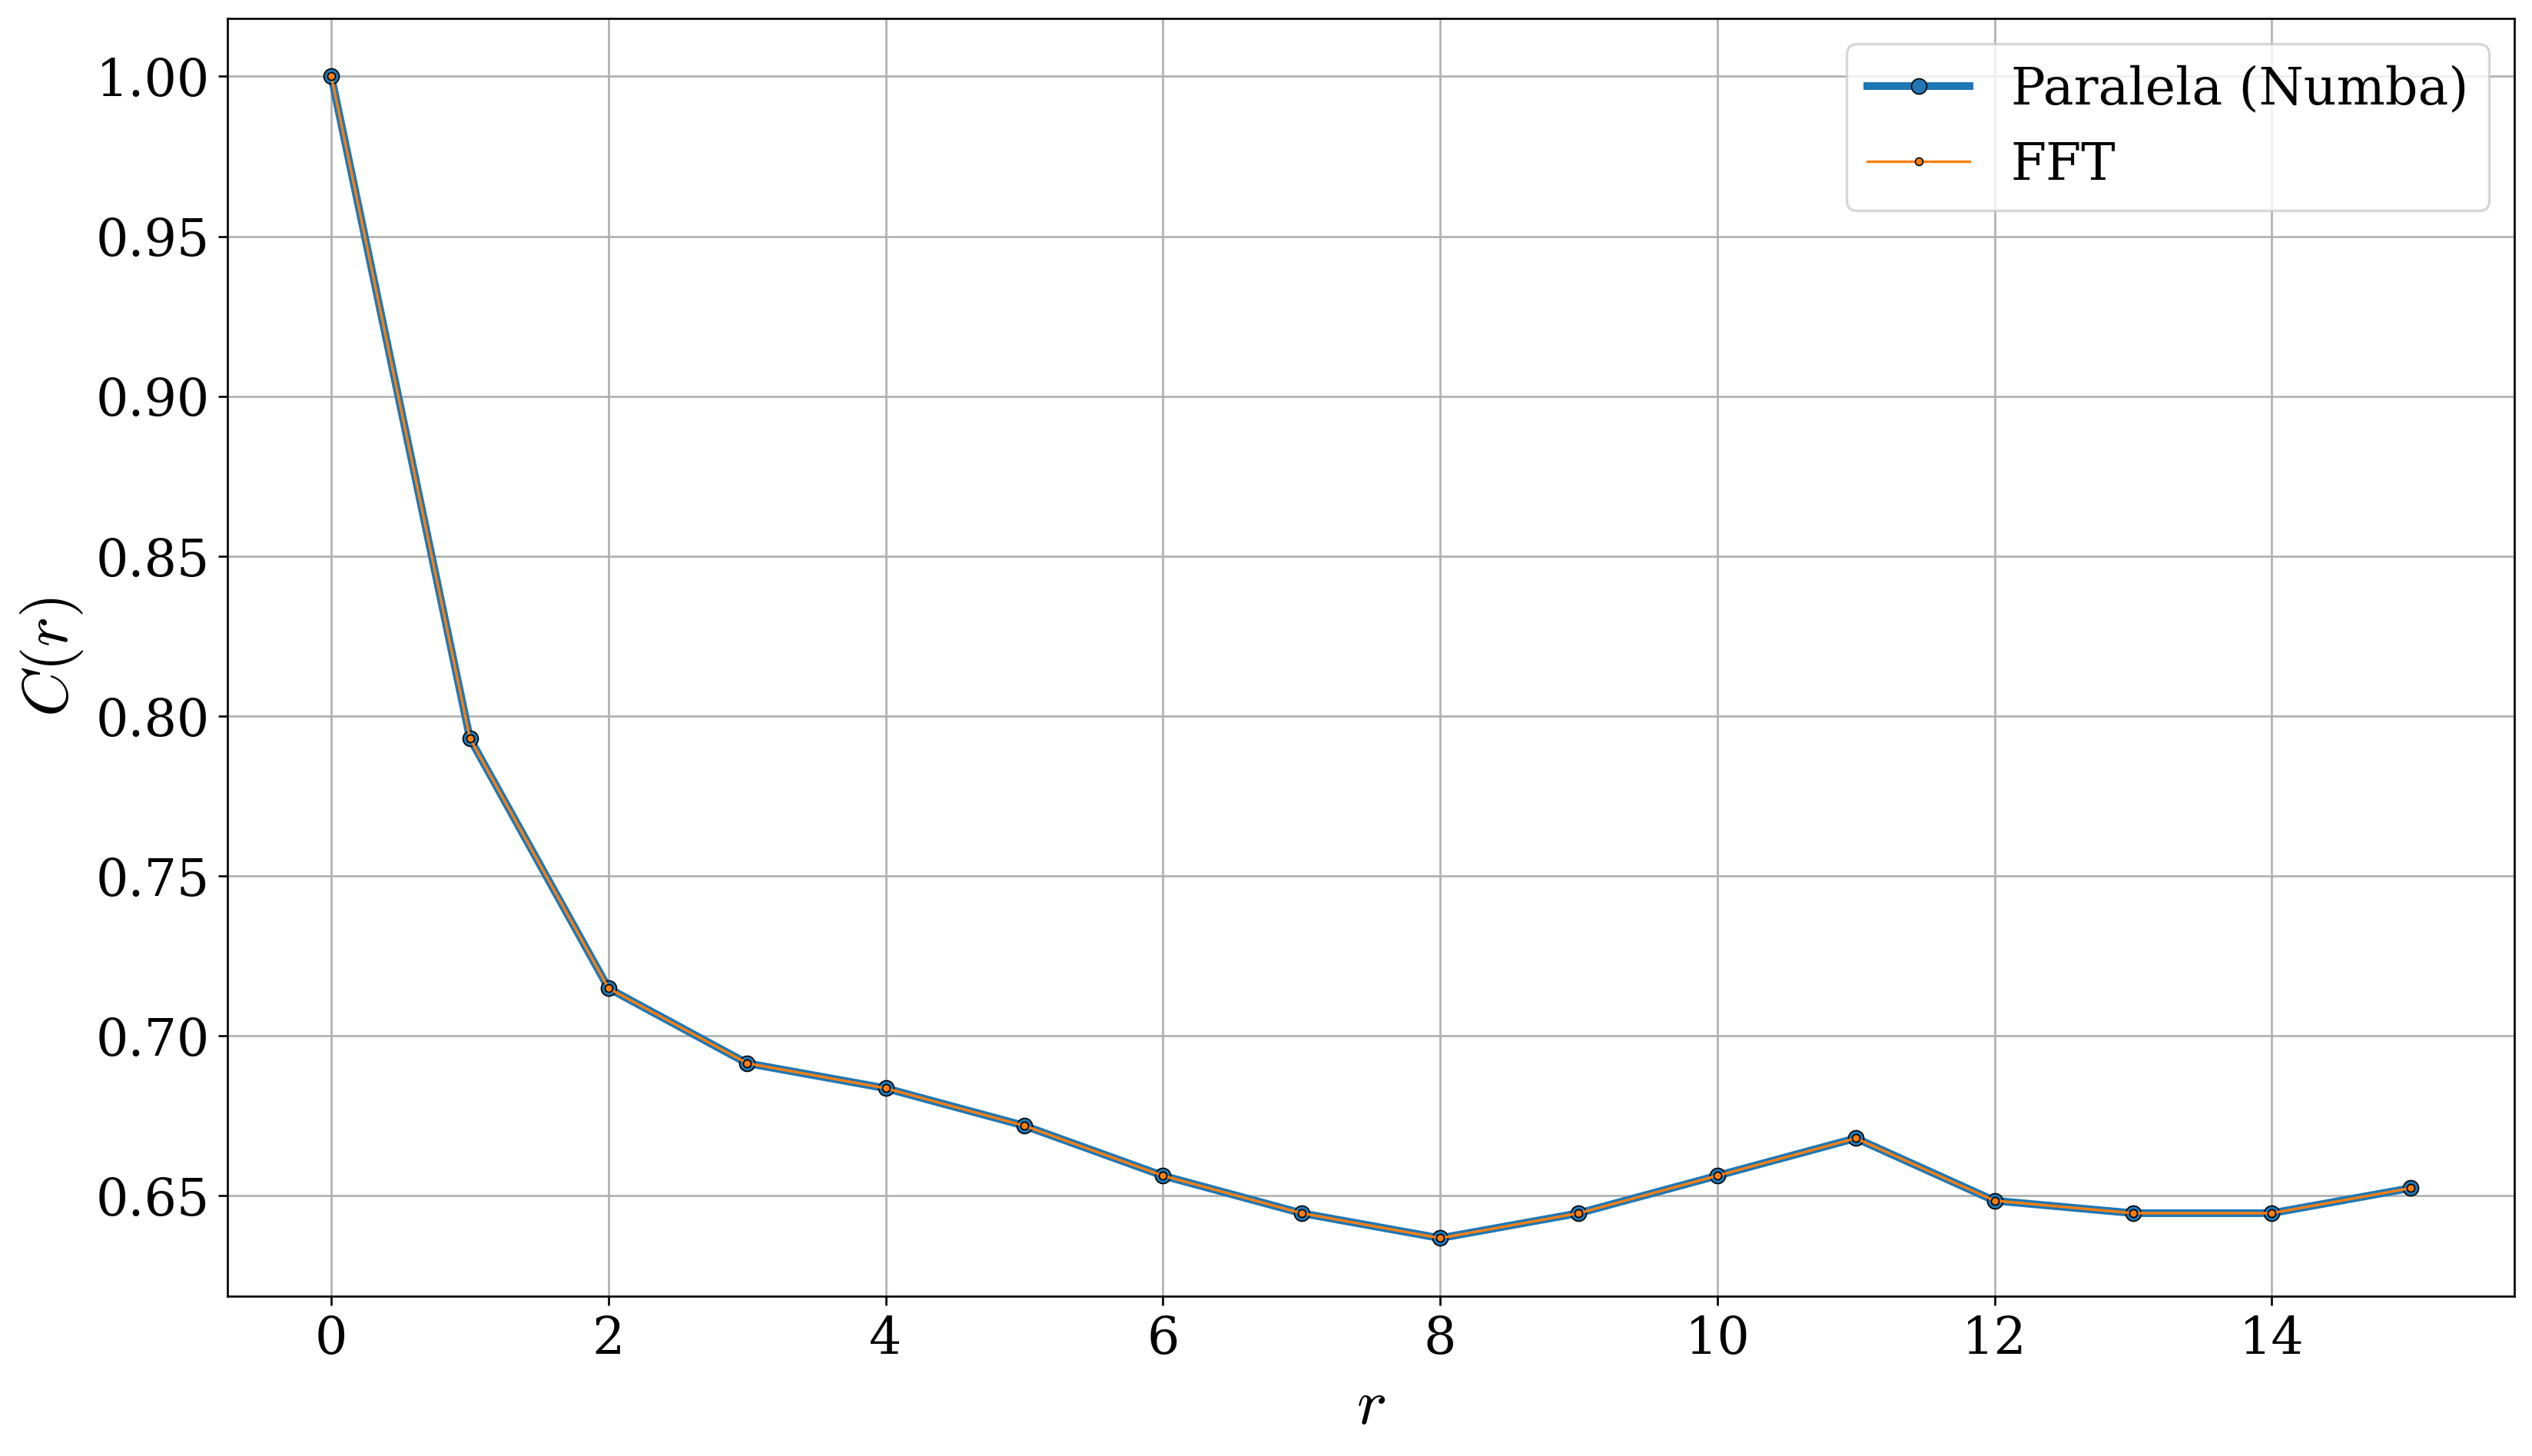

In [11]:
plt.plot(cor_paralela(S), "o-", mec="k", mew=0.5, lw=3, label="Paralela (Numba)")
plt.plot(cor_fft(S), ".-", mec="k", mew=0.5, lw=1, label="FFT")
plt.legend()
plt.xlabel("$r$")
plt.ylabel("$C(r)$")
plt.show()

Habiendo validado la equivalencia entre las implementaciones y la eficiencia superior del algoritmo basado en la FFT, procederemos aplicando este para definir la función `metropolis2`.

Dicho eso, dado que es dificil propagar los efectos de modificar un spin en el valor de $c(r)$ para toda la red, se propone calcular este valor antes y despues de dar los $L^2$ pasos del algoritmo `metropolis` y tomar su diferencia para calcular $dc$.

Luego, para aprovechar los cálculos sucesivos de $c(r)$, pasamos como parámetro el valor calculado a partir de la iteración anterior si este estuviera disponible.

In [12]:

def metropolis2(S: np.ndarray, prob: np.ndarray, cor_S: np.ndarray = None):
    # Aplica el algoritmo de Metropolis al estado S
    if cor_S is None:
        c_original = cor_fft(S)
    else:
        c_original = cor_S
    # La consigna dice que hay que aplicar el algoritmo de metrópolis por cada
    # sitio en la red, es decir, L cuadrado veces.
    S, dm, _ = metropolis(S, prob)
    dc = cor_fft(S) - c_original
    return S, dm, dc

## Ajustes a la Función de Correlación
La función de correlación es:
$$g(r) = \langle s_{ij}s_{ij+r}\rangle-\langle s_{ij}\rangle\langle s_{ij+r}\rangle$$
dónde puede notarse que $\langle s_{ij}\rangle = \langle s_{ij+r}\rangle = M$ 
$$\Rightarrow g(r) = \langle s_{ij}s_{ij+r}\rangle-M^2$$

Sabemos que en Ising 1D $g(r)\sim e^{-r/\xi}$ dónde $\xi$ es la longitud de correlación. Aunque en 2D puede deducirse de la aproximación de campo medio que $g(r) \sim \frac{e^{-r/\xi}}{(r/\xi)^\eta}$. Para estudiar la relación entre $\xi$ y $T$, queremos ajustar las correlaciones calculadas a partir de las redes que evolucionamos con `metropolis2`.

A continuación presentamos algunos ajustes de ejemplo a la función exponencial $\bar{g}(r) = A\cdot e^{-r/\xi} + C_0$ y a una expresión más compleja de la función de correlación $\hat{g}(r) = A\cdot\frac{e^{-r/\xi}}{(r/\xi)^\eta} + C_0$. En ambos casos agregamos un grado de libertad a los ajustes en la forma de una constante aditiva ya que tras múltiples intentos observamos que esto disminuía la dificultad de obtener ajustes.

In [44]:
def funcion_correlacion_exponencial(r, A, xi):
    return A * np.exp(-r / xi)


def funcion_correlacion_ley_potencias(r, A, eta, xi):
    return A * np.exp(-r / xi) * (r / xi)**(-eta)

Longitud de correlacion:


Midiendo T =1.5:   0%|          | 0/3485 [00:00<?, ?it/s]

Ajuste Exponencial:
T=1.5 => ξ=(0.411 ± 0.003)
Ajuste de Ley de Potencias:
T=1.5 => ξ=(0.415 ± 1)
         η=(-0.0289 ± 9)


Midiendo T =2.3:   0%|          | 0/14639 [00:00<?, ?it/s]

Ajuste Exponencial:
T=2.3 => ξ=(2.54 ± 0.003)
Ajuste de Ley de Potencias:
T=2.3 => ξ=(9.18 ± 0.1)
         η=(0.374 ± 0.003)


Midiendo T =3:   0%|          | 0/8209 [00:00<?, ?it/s]

Ajuste Exponencial:
T=3 => ξ=(1.16 ± 0.0005)
Ajuste de Ley de Potencias:
T=3 => ξ=(2.01 ± 0.01)
         η=(0.364 ± 0.006)


/tmp/ipykernel_16806/1612530372.py:6: RuntimeWarning: invalid value encountered in power
  return A * np.exp(-r / xi) * (r / xi)**(-eta) + C


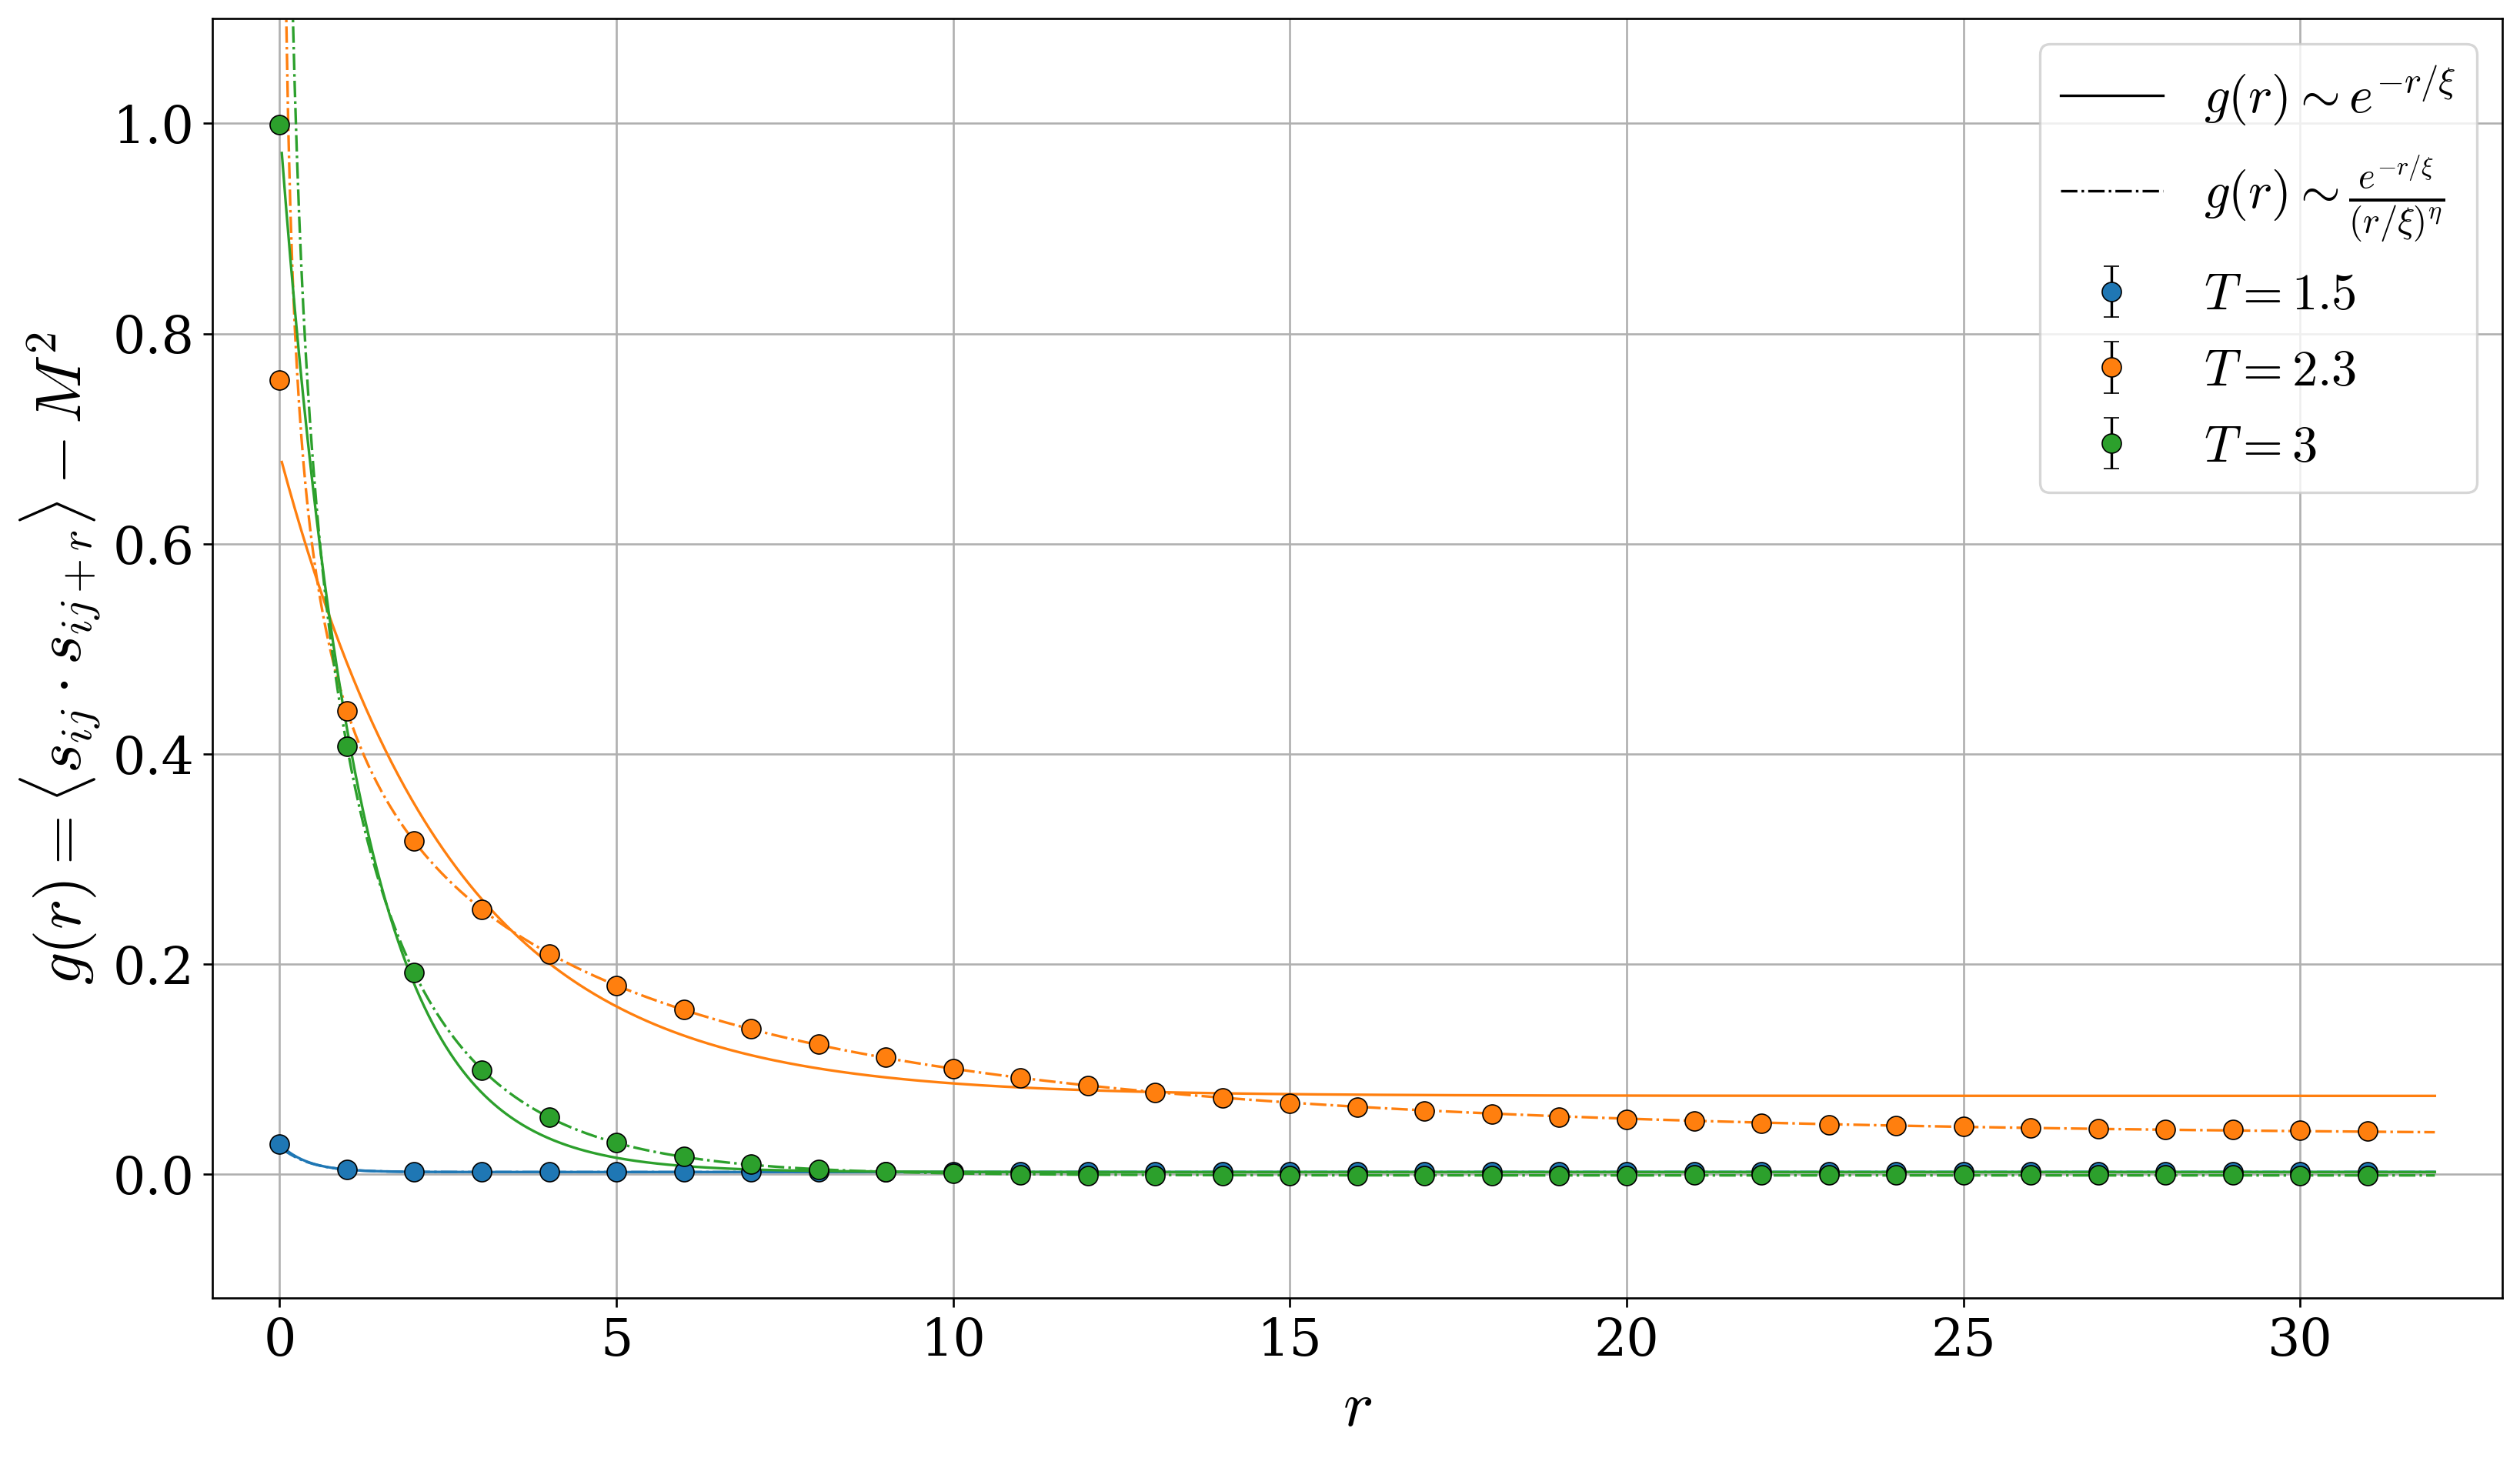

In [18]:
L = 64
l = L // 2  # numero de componentes del vector c

r_vals = np.arange(l)  # dominio de la funcion de correlacion
r_dense = np.linspace(0, l, 1_000)[1:]

S = np.ones((L, L), dtype=int)
print("Longitud de correlacion:")

for i, T in enumerate([1.5, 2.3, 3,]):
    npromedio = get_n_from_matrix(L, T)
    m = np.zeros(npromedio)  # magnetizacion en funcion del paso
    c = np.zeros((l, npromedio))  # vector c en funcion del paso
    beta = 1 / T
    prob = np.exp(-beta * np.array([4, 8]))
    # Termalizamos S antes de empezar a medir
    S = termalize_S(S, prob)
    m[0] = np.mean(S)
    c[:, 0] = cor_fft(S)
    for n in tqdm(range(1, npromedio), desc=f"Midiendo {T =}", leave=False):
        S, dm, dc = metropolis2(S, prob, c[:, n - 1])
        m[n] = m[n - 1] + dm
        c[:, n] = c[:, n - 1] + dc

    correlacion = np.mean(c - m**2, axis=1)
    correlacion_err = np.std(c - m**2, axis=1) / np.sqrt(npromedio)
    plt.errorbar(
        r_vals, correlacion, yerr=correlacion_err,
        fmt=".", c=f"C{i}", ms=15, mec="k", mew=0.5,
        ecolor="k", capsize=3, elinewidth=1, zorder=20,
        label=f"$T={T}$",
    )
    # Ajustamos por la función exponencial:
    popt, pcov = curve_fit(
        funcion_correlacion_exponencial,
        r_vals, correlacion,
        sigma=correlacion_err,
        absolute_sigma=True,
        # p0=[correlacion[0], 1],
        # bounds=(0, np.inf),
    )
    perr = np.sqrt(np.diag(pcov))
    print("Ajuste Exponencial:")
    print(f"T={T} => ξ=({popt[-1]:.3g} ± {perr[-1]:.1g})")
    plt.plot(
        r_dense, funcion_correlacion_exponencial(r_dense, *popt),
        "-", c=f"C{i}", lw=1,
    )
    # Ajustamos por la expresión con correcciones:
    # eta_teorico = 1/2 if T > 2.27 else 2 if T < 2.27 else 1/4
    popt, pcov = curve_fit(
        funcion_correlacion_ley_potencias,
        r_vals[1:], correlacion[1:],
        sigma=correlacion_err[1:],
        absolute_sigma=True,
        # p0=[popt[0], eta_teorico, popt[-1]],
        # bounds=(0, np.inf),
    )
    perr = np.sqrt(np.diag(pcov))
    print("Ajuste de Ley de Potencias:")
    print(f"T={T} => ξ=({popt[-1]:.3g} ± {perr[-1]:.1g})")
    print(f"         η=({popt[-2]:.3g} ± {perr[-2]:.1g})")
    plt.plot(
        r_dense, funcion_correlacion_ley_potencias(r_dense, *popt),
        "-.", c=f"C{i}", lw=1,
    )

plt.plot([], [], "-", c="k", lw=1, label=r"$g(r)\sim e^{-r/\xi}$")
plt.plot([], [], "-.", c="k", lw=1, label=r"$g(r) \sim \frac{e^{-r/\xi}}{(r/\xi)^\eta}$")
plt.legend()
plt.xlabel("$r$")
plt.ylabel(r"$g(r) = \langle s_{ij}\cdot s_{ij+r}\rangle-M^2$")
plt.ylim(top=1.1)
plt.xlim(-1, l + 1)
plt.show()

In [31]:
# Calculamos la correlación para muchas temperaturas (alrededor de la crítica):
L = 256
temperatura_critica = 2.27

try:
    T_vals, correlacion_cache = np.load(f"correlacion_data_L{L}.npz").values()
except FileNotFoundError:
    T_vals = create_dense_domain_around_tc(temperatura_critica, 51)
    correlacion_cache = np.empty((l, T_vals.size, 2), dtype=float)
    S = np.ones((L, L), dtype=int)
    for i, T in tqdm(
        enumerate(T_vals), desc="Temperaturas", leave=False, total=len(T_vals)
    ):
        npromedio = get_n_from_matrix(L, T)
        m = np.zeros(npromedio)  # magnetizacion en funcion del paso
        c = np.zeros((l, npromedio))  # vector c en funcion del paso
        beta = 1 / T
        prob = np.exp(-beta * np.array([4, 8]))
        # Termalizamos S antes de empezar a medir
        S = termalize_S(S, prob)
        # Inicializamos valores
        m[0] = np.mean(S)
        c[:, 0] = cor_fft(S)
        for n in range(1, npromedio):
            S, dm, dc = metropolis2(S, prob, c[:, n - 1])
            m[n] = m[n - 1] + dm
            c[:, n] = c[:, n - 1] + dc
        correlacion = np.mean(c - m**2, axis=1)
        correlacion_err = np.std(c - m**2, axis=1) / np.sqrt(npromedio)
        correlacion_cache[:, i] = np.array([correlacion, correlacion_err]).T
    np.savez(f"correlacion_data_L{L}.npz", T_vals=T_vals, correlacion=correlacion_cache)

/tmp/ipykernel_16806/2639747301.py:6: RuntimeWarning: invalid value encountered in power
  return A * np.exp(-r / xi) * (r / xi)**(-eta)
/tmp/ipykernel_16806/3521436805.py:32: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(
/tmp/ipykernel_16806/2639747301.py:6: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-r / xi) * (r / xi)**(-eta)
/tmp/ipykernel_16806/3521436805.py:47: RuntimeWarning: invalid value encountered in divide
  didnt_fit_1 = np.logical_or(xi1_fit == 0, xi1_err/xi1_fit > 1)


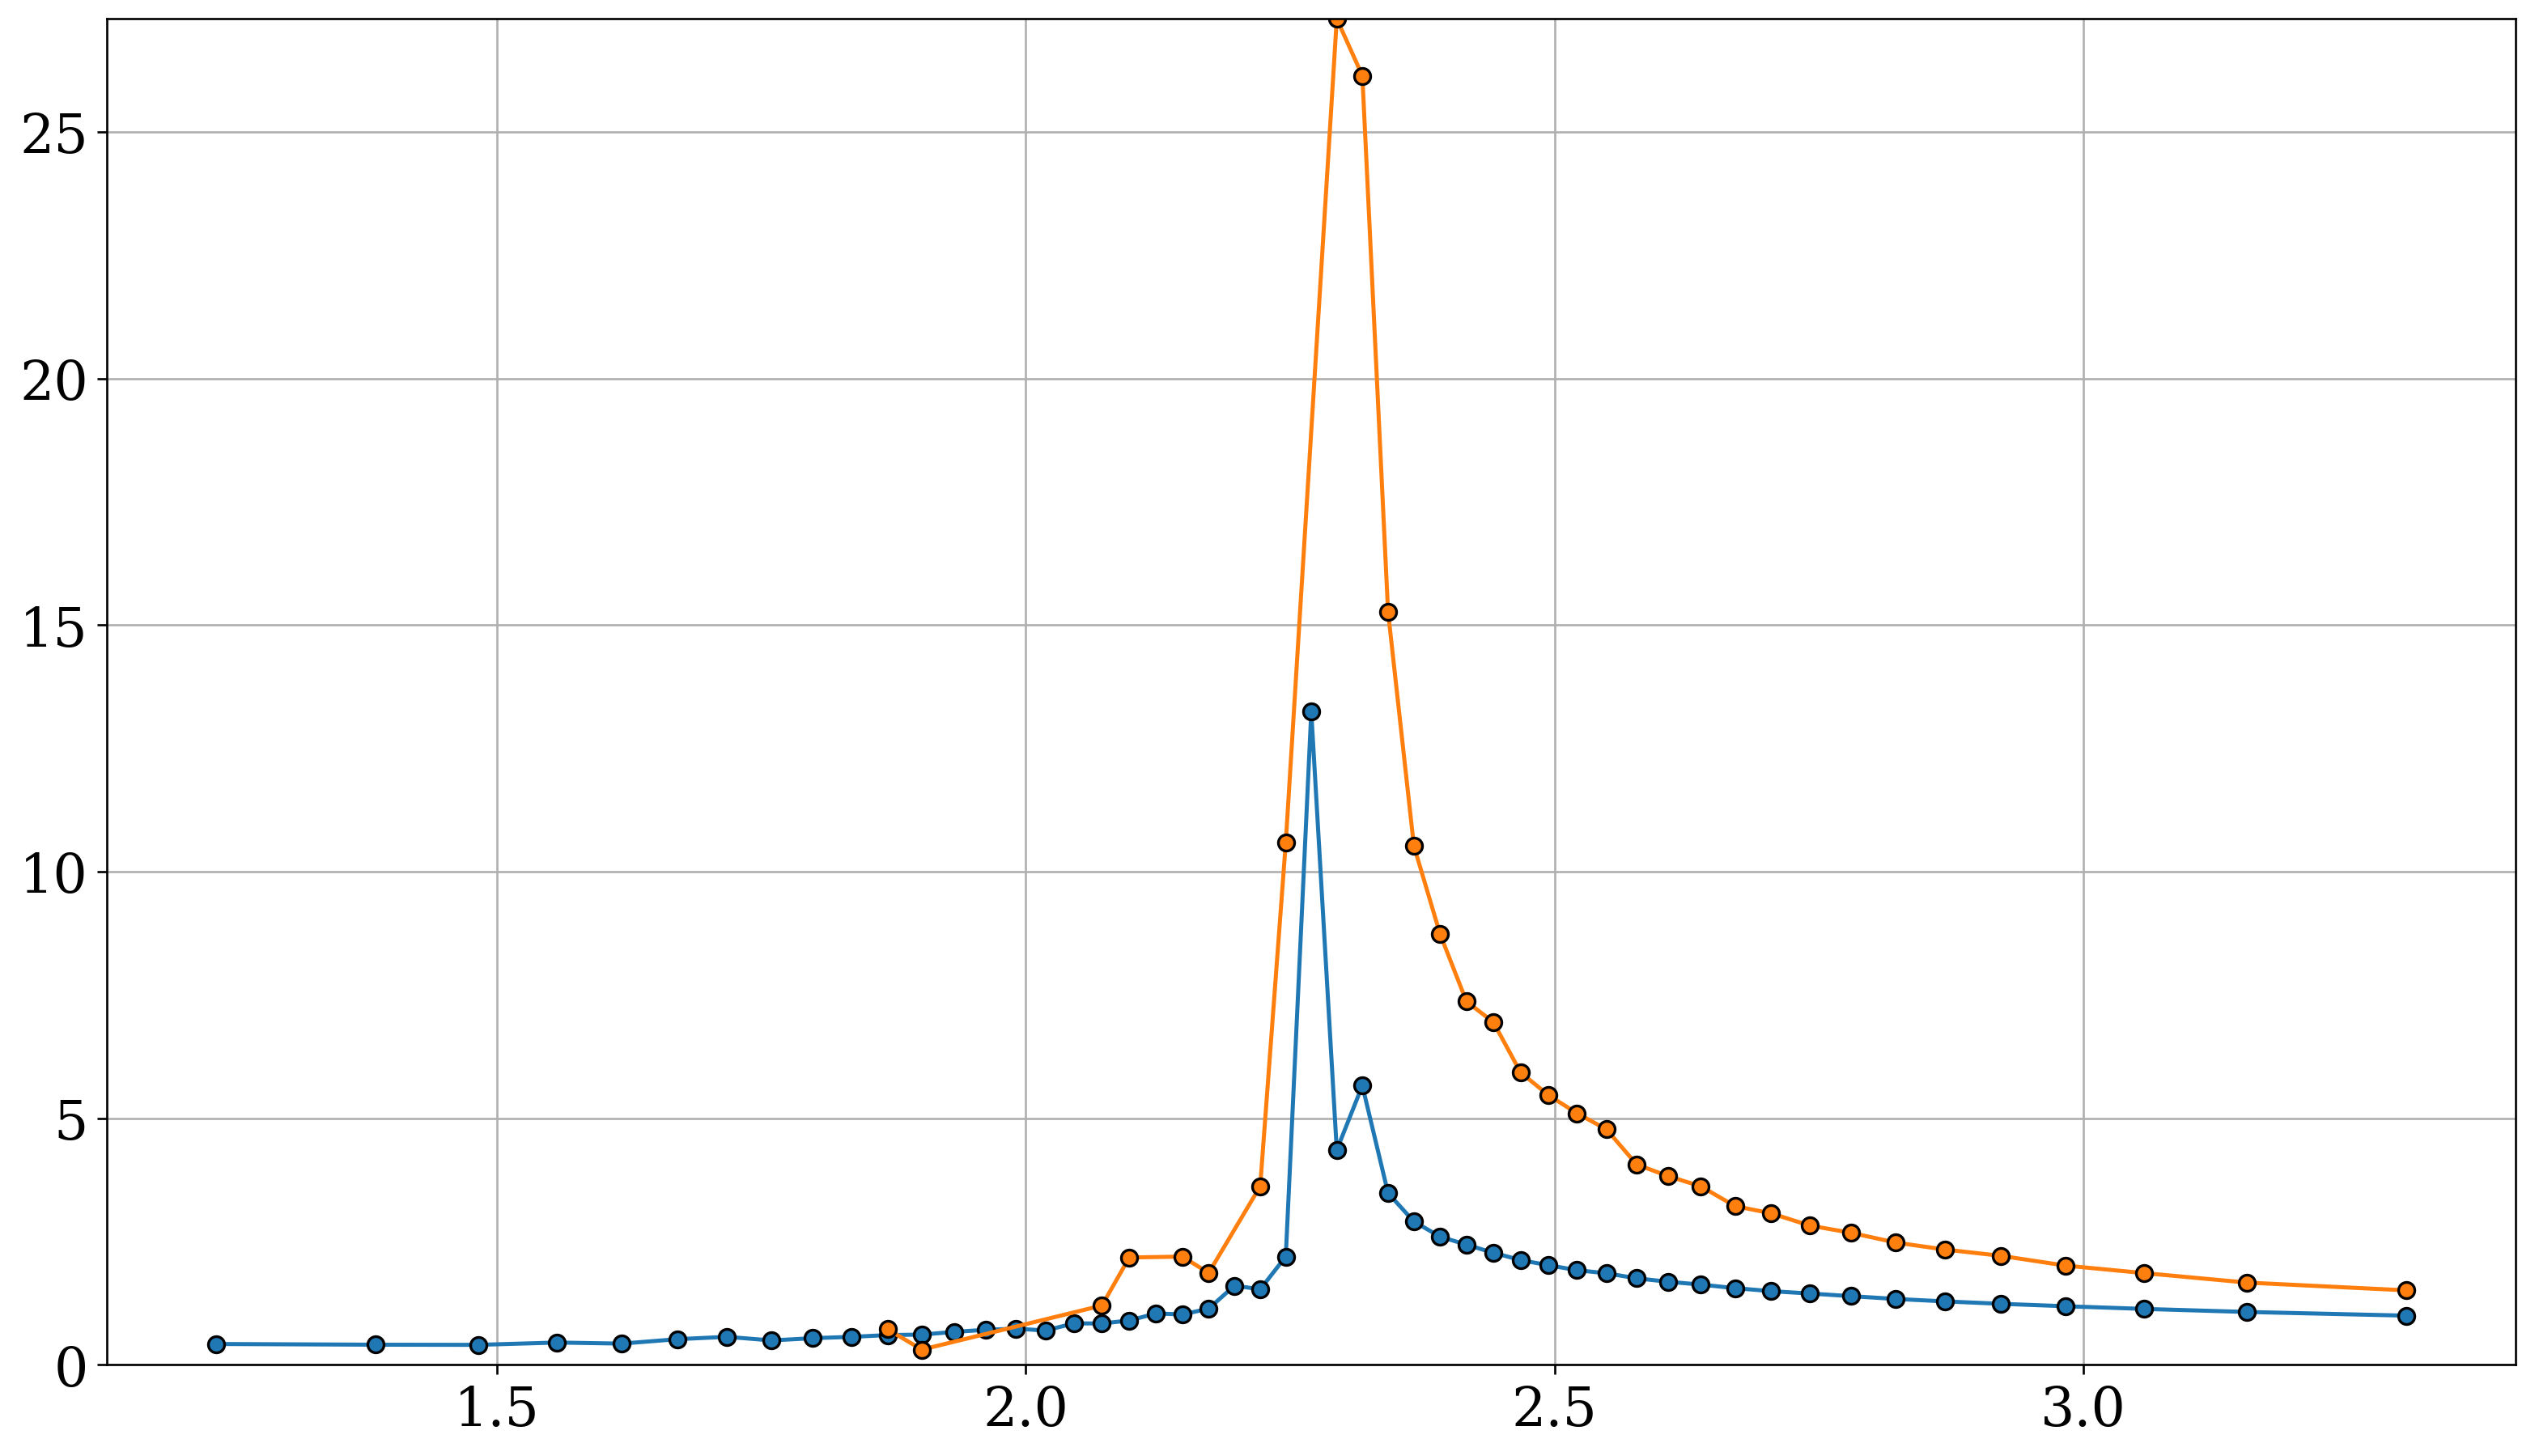

In [52]:
l = L // 2  # numero de componentes del vector c
r_vals = np.arange(l)  # dominio de la funcion de correlacion
# Para los resultados de los ajustes a `funcion_correlacion_exponencial`
xi0_fit = np.zeros_like(T_vals)
xi0_err = np.zeros_like(T_vals)
# Para los resultados de los ajustes a `funcion_correlacion_ley_potencias`
xi1_fit = np.zeros_like(T_vals)
xi1_err = np.zeros_like(T_vals)
eta_fit = np.zeros_like(T_vals)
eta_err = np.zeros_like(T_vals)

for i, T in enumerate(T_vals):
    correlacion = correlacion_cache[:, i, 0]
    correlacion_err = correlacion_cache[:, i, 1]
    try:
        # Ajustamos por la función exponencial:
        popt, pcov = curve_fit(
            funcion_correlacion_exponencial,
            r_vals, correlacion,
            sigma=correlacion_err,
            absolute_sigma=True,
            # p0=[correlacion[0], 1],
            # bounds=(0, np.inf),
        )
        perr = np.sqrt(np.diag(pcov))
        xi0_fit[i], xi0_err[i] = popt[-1], perr[-1]
    except RuntimeError:
        pass
    try:
        # Ajustamos por la expresión con correcciones:
        # eta_teorico = 1/2 if T > 2.27 else 2 if T < 2.27 else 1/4
        popt, pcov = curve_fit(
            funcion_correlacion_ley_potencias,
            r_vals[1:], correlacion[1:],
            sigma=correlacion_err[1:],
            absolute_sigma=True,
            # p0=[popt[0], eta_teorico, popt[-1]],
            # bounds=(0, np.inf),
        )
        perr = np.sqrt(np.diag(pcov))
        xi1_fit[i], xi1_err[i] = popt[-1], perr[-1]
        eta_fit[i], eta_err[i] = popt[-2], perr[-2]
    except RuntimeError:
        pass

didnt_fit_0 = np.logical_or(xi0_fit == 0, xi0_err/xi0_fit > 1)
didnt_fit_1 = np.logical_or(xi1_fit == 0, xi1_err/xi1_fit > 1)
xi0_fit = xi0_fit[~ didnt_fit_0]
xi0_err = xi0_err[~ didnt_fit_0]
xi1_fit = xi1_fit[~ didnt_fit_1]
xi1_err = xi1_err[~ didnt_fit_1]

plt.errorbar(
    T_vals[~ didnt_fit_0], xi0_fit, yerr=xi0_err, fmt="o-", mec="k", ecolor="k"
)
plt.errorbar(
    T_vals[~ didnt_fit_1], xi1_fit, yerr=xi1_err, fmt="o-", mec="k", ecolor="k"
)
plt.ylim(0, max(max(xi1_fit), max(xi0_fit)))
plt.show()